# MOOC Data Preprocessing

In [1]:
import pandas as pd
import re
import json

file_path = 'all_courses.json'
data = pd.read_json(file_path)

# Функция для очистки и разделения syllabus
def clean_syllabus(syllabus):
    if pd.isna(syllabus) or not syllabus.strip():
        return []  # Возвращаем пустой список, если данные отсутствуют или пусты

    # Убираем все упоминания "Модуль X", "Тема X", "Часть X" и другие
    syllabus = re.sub(r'\s*(Вводный|Введение|Заключение|Тема|Модуль|Модули|Часть|Глава|Раздел|Лекция|Занятие|Неделя|Уровень|Урок|Module|Lecture|Структура|Структура курса|Программа(?: курса)?)\s*\d+', '', syllabus)

    # Убираем цифры, "прилипшие" к словам (например, "проекта5" → "проекта")
    syllabus = re.sub(r'(?<=[А-Яа-яёA-Za-z])\d+', '', syllabus)

    # Убираем цифры в начале строк (например, "1. Текст" → "Текст")
    syllabus = re.sub(r'^\d+[.\s]*', '', syllabus)

    # Убираем кавычки и пробелы
    syllabus = syllabus.replace('«', '').replace('»', '').strip()

    # Убираем переносы
    syllabus = re.sub(r'\(\s*\n\s*', '(', syllabus)
    syllabus = re.sub(r'\s*\n\s*\)', ')', syllabus)

    # Временная замена точек внутри скобок, инициалов и сокращений
    syllabus = re.sub(r'\([^)]*\)', lambda x: x.group(0).replace('.', '<dot>').replace(';', '<semicolon>'), syllabus)
    syllabus = re.sub(r'\b([А-ЯЁ])\.\s*([А-ЯЁ])\.', r'\1<dot> \2<dot>', syllabus)  # Инициалы
    syllabus = re.sub(r'\b([А-ЯЁ])\.([А-ЯЁ])\.', r'\1<dot>\2<dot>', syllabus)  # Сокращения

    # Добавляем пробел после точки, если его нет (чтобы не склеивались слова)
    syllabus = re.sub(r'(?<=[а-яёА-ЯЁa-zA-Z])\.(?=[А-ЯЁA-Z])', '. ', syllabus)

    # Разделение слитных слов (маленькая → заглавная), кроме аббревиатур (2+ заглавных подряд)
    syllabus = re.sub(r'(?<=[а-яёa-z])(?=[А-ЯЁA-Z][а-яёa-z])', '. ', syllabus)

    # Разделяем текст по точкам, точкам с запятой и двоеточиям
    syllabus_items = re.split(r'[.;]', syllabus)

    # Восстанавливаем заменённые точки и точки с запятой
    syllabus_items = [item.replace('<dot>', '.').replace('<semicolon>', ';') for item in syllabus_items]

    # Убираем цифры в начале каждого элемента списка
    syllabus_items = [re.sub(r'^\d+[.\s]*', '', item).strip() for item in syllabus_items if item.strip()]

    # Убираем пустые строки
    syllabus_items = [item for item in syllabus_items if item.strip()]

    return syllabus_items

# Применяем функцию к syllabus
data['syllabus'] = data['syllabus'].apply(clean_syllabus)

# output_file = 'cleaned_courses.json'
# data.to_json(output_file, orient='records', force_ascii=False, indent=4)

# print(f"Обработанный файл сохранён как {output_file}")


In [2]:
# Функция для очистки result_knowledge
def clean_result_knowledge(text):
    if pd.isna(text) or not text.strip():
        return []

    # Убираем вводные фразы
    text = re.sub(
        r'(?i)(по завершении[^:]+:|в результате изучения[^:]+:|в результате прохождения[^:]+:|в процессе освоения[^:]+:|по окончании[^:]+:|upon completion[^:]+:)',
        '', text
    ).strip()

    # Убираем "Знать", "Уметь", "Владеть"
    text = re.sub(r'\b(Знать|Уметь|Владеть|Вы нвучитесь)\b', '', text).strip()

    # Убираем все цифры и двоеточия перед текстом
    text = re.sub(r'^\s*[:\d]+\s*', '', text)  # В начале строки
    text = re.sub(r'(?<=[:\s])\d+\s*', '', text)  # После двоеточия или пробела
    text = re.sub(r'^\s*:\s*', '', text)  # Убираем ":" перед словами
    text = re.sub(r'^\s*\d+[.\s:]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\b\d+[.:]?\s*', '', text)

    # Временная замена точек внутри скобок, кавычек и сокращений
    text = re.sub(r'\([^)]*\)', lambda x: x.group(0).replace('.', '<dot>').replace(';', '<semicolon>'), text)
    text = re.sub(r'«[^»]*»', lambda x: x.group(0).replace('.', '<dot>').replace(';', '<semicolon>'), text)
    text = re.sub(r'\b([а-яёА-ЯЁ])\.\s*([а-яёА-ЯЁ])\.', r'\1<dot> \2<dot>', text)  # Инициалы
    text = re.sub(r'\b([а-яёА-ЯЁ])\.([а-яёА-ЯЁ])\.', r'\1<dot>\2<dot>', text)  # Сокращения (т.ч., и т.д.)

    # # Разделяем слова, если нет пробела между строчными и заглавными буквами (например, "поймутосновы" → "поймут. основы")
    # text = re.sub(r'(?<=[а-яёa-z])(?=[А-ЯЁA-Z])', '. ', text)

    # Разделяем текст по точкам и точкам с запятой
    sentences = re.split(r'[.;:]', text)

    # Восстанавливаем заменённые точки и точки с запятой
    sentences = [s.replace('<dot>', '.').replace('<semicolon>', ';') for s in sentences]

    # Убираем пустые строки и лишние пробелы
    sentences = [s.strip() for s in sentences if s.strip()]

    return sentences

# Применяем функцию к result_knowledge
data['result_knowledge'] = data['result_knowledge'].apply(clean_result_knowledge)

# output_file = 'cleaned_courses.json'
# data.to_json(output_file, orient='records', force_ascii=False, indent=4)

# print(f"Обработанный файл сохранён как {output_file}")


In [4]:
def clean_text(text):
    if pd.isna(text) or not text.strip():
        return []

    # Оставляем только важные части текста, начиная с ключевых слов
    text = re.sub(r'^.*?(Регулятивные УУД1)', r'\1', text, flags=re.DOTALL)
    # Убираем вводные фразы
    text = re.sub(r'Обучающийся сможет:\s*', '', text)

    # Убираем кодировки типа "ПК-1", "ОК-3" и т.д.
    text = re.sub(r'[А-ЯЁA-Z]{2,4}-\d+\s*', '', text)
    text = re.sub(r'[А-ЯЁA-Z]{2,4}\d+\s*', '', text)

    # Удаляем цифры в начале строк (1, 2, 3, ...) и их возможные пробелы
    text = re.sub(r'^\d+\s*', '', text)

    # Удаляем лишние пробелы, точки и спецсимволы в начале фраз
    text = re.sub(r'^[\s·•\-:–]+', '', text)

    # Временная замена точек внутри скобок, кавычек и сокращений
    text = re.sub(r'\([^)]*\)', lambda x: x.group(0).replace('.', '<dot>').replace(';', '<semicolon>'), text)
    text = re.sub(r'«[^»]*»', lambda x: x.group(0).replace('.', '<dot>').replace(';', '<semicolon>'), text)
    text = re.sub(r'\b([а-яёА-ЯЁ])\.\s*([а-яёА-ЯЁ])\.', r'\1<dot> \2<dot>', text)  # Инициалы
    text = re.sub(r'\b([а-яёА-ЯЁ])\.([а-яёА-ЯЁ])\.', r'\1<dot>\2<dot>', text)  # Сокращения (т.ч., и т.д.)

    # Разделяем текст по точкам, запятым, точкам с запятой и переводам строк
    phrases = re.split(r'[.;\n]', text)

    # Восстанавливаем заменённые точки и точки с запятой
    phrases = [s.replace('<dot>', '.').replace('<semicolon>', ';') for s in phrases]

    # Дополнительная обработка фраз
    phrases = [re.sub(r'([а-яё])([А-ЯЁ])', r'\1. \2', phrase) for phrase in phrases]
    phrases = [re.sub(r'^[\s\-–—\.\*\,]+', '', phrase.strip()) for phrase in phrases if phrase.strip()]

    # Убираем лишние пробелы и пустые строки
    phrases = [phrase.strip() for phrase in phrases if phrase.strip()]

    return phrases

# Применяем к competence
data['competence'] = data['competence'].apply(clean_text)

output_file = 'cleaned_courses2.json'
data.to_json(output_file, orient='records', force_ascii=False, indent=4)

print(f"Обработанный файл сохранён как {output_file}")


Обработанный файл сохранён как cleaned_courses2.json


In [7]:
import csv
import pandas as pd
import re

df=pd.read_csv('cleaned_courses.csv')

 # Преобразование списков в строки с разделителем ";"
df['syllabus'] = df['syllabus'].apply(lambda x: '; '.join(eval(x)))
df['result_knowledge'] = df['result_knowledge'].apply(lambda x: '; '.join(eval(x)))
df['competence'] = df['competence'].apply(lambda x: '; '.join(eval(x)))

# Список слов для удаления
words_to_remove = ["Вы узнаете", "Навыки после прохождения курса", "В процессе освоения курса обучающийся",
                   "Обучающийся в полном объеме", "Вы научитесь:", "Введение", "Заключение"]

# Функция для удаления указанных слов
def remove_words(text, words):
    for word in words:
        text = text.replace(word, "")
    return text.strip()

# Применение функции к нужным столбцам
df["syllabus"] = df["syllabus"].apply(remove_words, words=words_to_remove)
df["result_knowledge"] = df["result_knowledge"].apply(remove_words, words=words_to_remove)
df["competence"] = df["competence"].apply(remove_words, words=words_to_remove)

# Вывод результата
df

title  \
0                                       Психология   
1                   Создание и реализация проектов   
2              Биоэтика: хорошо и плохо в биологии   
3                    Основы проектной деятельности   
4         Проектирование портфолио в Figma и Tilda   
...                                            ...   
1120            Основы информационной безопасности   
1121                 Основы проектной деятельности   
1122              Основы технологии машиностроения   
1123             Современный стратегический анализ   
1124  Математические методы управления перевозками   

                                                   link  \
0     https://openedu.ru/course/spbu/PSYCO/?session=...   
1     https://openedu.ru/course/spbu/PROJECT2/?sessi...   
2     https://openedu.ru/course/spbu/BIOSCHOOL/?sess...   
3     https://openedu.ru/course/spbu/PROJECT1/?sessi...   
4     https://openedu.ru/course/spbu/FIGMA_TILDA/?se...   
...                                                 ...   
1120  https://openedu.ru/course/spbstu/FINFSEC/?sess...   
1121  https://openedu.ru/course/spbstu/OPD/?session=...   
1122  https://openedu.ru/course/spbstu/TMASH/?sessio...   
1123  https://openedu.ru/course/spbstu/MSTRAN/?sessi...   
1124  https://openedu.ru/course/spbstu/MMTM/?session...   

                                            description  \
0     Уважаемые слушатели, некоторые материалы данно...   
1     Уважаемые слушатели, некоторые материалы данно...   
2     Уважаемые слушатели, некоторые материалы данно...   
3     Уважаемые слушатели, некоторые материалы данно...   
4     Уважаемые слушатели, некоторые материалы данно...   
...                                                 ...   
1120  Курс посвящен задаче обеспечения информационно...   
1121  Применение инструментов проектного подхода пом...   
1122  Цель изучения курса — научиться проектировать ...   
1123  Курс направлен на изучение различных школ, нап...   
1124  Курс адресован тем, кто хочет сделать успешную...   

                                           about_course  \
0     Курс ориентирован на обучающихся на обучающихс...   
1     Благодаря освоению онлайн-курса сформируется п...   
2     Про биоэтику говорят, что это современная межд...   
3     Освоение курса по основам проектной деятельнос...   
4     Практико-ориентированный курс посвящен базовой...   
...                                                 ...   
1120  Обеспечение информационной безопасности компью...   
1121  Проектная деятельность без знания основ похожа...   
1122  Технология машиностроения — область техническо...   
1123  Цель онлайн курса- сформировать у слушателей с...   
1124  Любое предприятие, занимающееся вопросами план...   

                                          course_format  \
0     Форма обучения заочная (дистанционная). Еженед...   
1     Форма обучения заочная (дистанционная). Еженед...   
2     Форма обучения заочная (дистанционная). Еженед...   
3     Форма обучения заочная (дистанционная). Еженед...   
4     Форма обучения заочная (дистанционная). Еженед...   
...                                                 ...   
1120  Курс ориентирован на слушателей различной нача...   
1121  Еженедельные занятия включают:просмотр тематич...   
1122  Курс «Основы технологии машиностроения» состои...   
1123  Курс «Современный стратегический анализ» включ...   
1124  При прохождении курса каждую неделю обучающиес...   

                                               syllabus  \
0     Психология как наука; Психология как практика;...   
1     Разработка и реализация стартапа; Разработка и...   
2     Этика – что это такое?; Этика в науке; Особенн...   
3     в проектную деятельность и презентация проекта...   
4     Портфолио в вебе; Композиция и пропорции в веб...   
...                                                 ...   
1120  Программа курса построена последовательно от к...   
1121  Общеепредставление о проектной деятельности; Ч...   
1122  В курсе рассматриваются

Cleaned_courses - это датасет после ручной допроверки

# Duplicates

In [8]:
# Поиск дубликатов в столбце 'link'
duplicates = df[df.duplicated('link', keep=False)]

# Сортировка по столбцу 'title' для удобства просмотра
duplicates_sorted = duplicates.sort_values(by='title')

duplicates_sorted

title  \
818   Additive Technologies in Metallurgy and Mechan...   
494   Additive Technologies in Metallurgy and Mechan...   
403                        Arabic for Beginners. Part 2   
72                         Arabic for Beginners. Part 2   
73                         Arabic for Beginners. Part 3   
...                                                 ...   
1024                                   Ядерная медицина   
375                    Японский для начинающих. Часть 3   
282                    Японский для начинающих. Часть 3   
376                    Японский для начинающих. Часть 4   
283                    Японский для начинающих. Часть 4   

                                                   link  \
818   https://openedu.ru/course/spbstu/ADTMME/?sessi...   
494   https://openedu.ru/course/spbstu/ADTMME/?sessi...   
403   https://openedu.ru/course/spbu/ARABIC2/?sessio...   
72    https://openedu.ru/course/spbu/ARABIC2/?sessio...   
73    https://openedu.ru/course/spbu/ARABIC3/?sessio...   
...                                                 ...   
1024  https://openedu.ru/course/urfu/NUCMED/?session...   
375   https://openedu.ru/course/spbu/JPLANG3/?sessio...   
282   https://openedu.ru/course/spbu/JPLANG3/?sessio...   
376   https://openedu.ru/course/spbu/JPLANG4/?sessio...   
283   https://openedu.ru/course/spbu/JPLANG4/?sessio...   

                                            description  \
818   Every teenager is ready to answer the question...   
494   Every teenager is ready to answer the question...   
403   Dear learners, please note that only part of t...   
72    Dear learners, please note that only part of t...   
73    Dear learners, please note that only part of t...   
...                                                 ...   
1024  Курс посвящен рассмотрению различных аспектов ...   
375   Японский язык является, пожалуй, одним из самы...   
282   Японский язык является, пожалуй, одним из самы...   
376   Японский язык является, пожалуй, одним из самы...   
283   Японский язык является, пожалуй, одним из самы...   

                                           about_course  \
818   The use of additive technologies is one of the...   
494   The use of additive technologies is one of the...   
403   This course consists of five modules and each ...   
72    This course consists of five modules and each ...   
73    The course was developed by teachers and profe...   
...                                                 ...   
1024  Курс посвящен всестороннему междисциплинарному...   
375   Для кого этот курс?Мы создали простой и понятн...   
282   Для кого этот курс?Мы создали простой и понятн...   
376   Для кого этот курс?Мы создали простой и понятн...   
283   Для кого этот курс?Мы создали простой и понятн...   

                                          course_format  \
818   The entire course is designed for 6 weeks. As ...   
494   The entire course is designed for 6 weeks. As ...   
403   The form of education is online. Weekly classe...   
72    The form of education is online. Weekly classe...   
73    The form of education is online. Weekly classe...   
...                                                 ...   
1024  Разделы курса включают видеолекции, проблемные...   
375                                       Дистанционный   
282                                       Дистанционный   
376                                       Дистанционный   
283                                       Дистанционный   

                                               syllabus  \
818   Metallurgical and mechanical engineering indus...   
494   Metallurgical and mechanical engineering indus...   
403   - Grammar Categories Noun: Definiteness Gender...   
72                                                        
73                                                        
...                                                 ...   
1024  Основные понятия ядерной медицины; Клинические...   
375   В первом модуле нас ждет:зн

In [9]:
def count_filled_columns(row):
    return row.notna().sum() + sum(len(x) > 0 if isinstance(x, (list, str)) else False for x in row)

# Применение функции к каждой строке
df['filled_columns'] = df.apply(count_filled_columns, axis=1)

# Группировка по 'title' и выбор строки с максимальным количеством заполненных колонок
filtered_df = df.loc[df.groupby('link')['filled_columns'].idxmax()]

# Удаление вспомогательной колонки
filtered_df = filtered_df.drop(columns=['filled_columns'])

filtered_df

title  \
798                      Алгоритмы и структуры данных-1   
799                      Алгоритмы и структуры данных-2   
259                       Основания алгебры и геометрии   
169           Анализ инвестиционных проектов и программ   
466          Арабский мир: история, политика, экономика   
...                                                 ...   
1031          Беспроводные телекоммуникационные системы   
515                                        Теплотехника   
994               Теория решения изобретательских задач   
992   Теория вероятностей и математическая статистик...   
991   Строительные технологии на основе хризотилцеме...   

                                                   link  \
798   https://openedu.ru/course/hse/ADS_1/?session=2023   
799   https://openedu.ru/course/hse/ADS_2/?session=2023   
259   https://openedu.ru/course/hse/AGBASE/?session=...   
169    https://openedu.ru/course/hse/AIPP/?session=2022   
466   https://openedu.ru/course/hse/ARABWORLD/?sessi...   
...                                                 ...   
1031  https://openedu.ru/course/urfu/TELECOM/?sessio...   
515   https://openedu.ru/course/urfu/TEPL/?session=s...   
994   https://openedu.ru/course/urfu/TRIZ/?session=s...   
992   https://openedu.ru/course/urfu/TheorVer/?sessi...   
991   https://openedu.ru/course/urfu/chryso/?session...   

                                            description  \
798   Курс "Алгоритмы и структуры данных-1" посвящен...   
799   Курс "Алгоритмы и структуры данных-2" рассчита...   
259   Не секрет, что в школах учат одной математике,...   
169   В курсе изучаются основные приемы финансово-эк...   
466   В рамках стратегии «Поворот на Восток» возраст...   
...                                                 ...   
1031                                         Нет данных   
515   ​В данном курсе излагаются основы технической ...   
994   Курс ориентирован на развитие умений пользоват...   
992   Целью изучения онлайн-курса является формирова...   
991   Курс «Строительные технологии на основе хризот...   

                                           about_course  \
798   Пройдя курс, вы научитесь решать задачи, котор...   
799   Пройдя курс, вы расширите ваш багаж знаний по ...   
259   Онлайн-курс от НИУ ВШЭ позволит изучить все те...   
169   Курс нацелен на развитие навыков применения фи...   
466   Курс направлен на формирование универсальных и...   
...                                                 ...   
1031  Курс направлен на формирование представлений о...   
515   Теплотехника – комплексная научная дисциплина,...   
994   Содержание курса направлено на изучение основ ...   
992   Случай привносит в нашу жизнь и профессиональн...   
991   Курс «Строительные технологии на основе хризот...   

                                          course_format  \
798   Курс состоит из 7 недель. Каждая неделя содерж...   
799   Курс состоит из 7 недель. Каждая неделя содерж...   
259   Курс состоит из коротких видеолекций от 7 до 1...   
169   Курс состоит из 10 недель. Каждая неделя содер...   
466   Курс состоит из 7 недель. Каждая неделя содерж...   
...                                                 ...   
1031  Еженедельные занятия будут включать просмотр в...   
515   Еженедельные занятия будут включать просмотр т...   
994   Еженедельно обучающимся предлагается изучить с...   
992   Структура курса включает:видеолекции с изложен...   
991   Разделы курса включают видеолекции, текстовые ...   

                                               syllabus  \
798   Сложность, тестирование, особые случаи; Линейн...   
799   Стек, очередь, дек; Динамическое программирова...   
259   Натуральные числа; Принцип математической инду...   
169   Основные игроки на рынке реального инвестирова...   
466   Появление арабских стран на политической карте...   
...                                                 ...   
1031  Беспроводная передача информации; Модели канал...   
515   Техническая термодинамика; 

In [13]:
# Поиск дубликатов в столбце 'link'
duplicates = filtered_df[filtered_df.duplicated('link', keep=False)]

# Сортировка по столбцу 'title' для удобства просмотра
duplicates_sorted = duplicates.sort_values(by='title')

duplicates_sorted

Empty DataFrame
Columns: [title, link, description, about_course, course_format, syllabus, result_knowledge, competence, groups]
Index: []

In [16]:
filtered_df.to_csv('dupl_cleaned_MOOC.csv')

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# EDA после предобработки

In [17]:
import pandas as pd
import numpy as np

df=pd.read_csv('dupl_cleaned_MOOC.csv')
df.head(3)

Unnamed: 0                           title  \
0         798  Алгоритмы и структуры данных-1   
1         799  Алгоритмы и структуры данных-2   
2         259   Основания алгебры и геометрии   

                                                link  \
0  https://openedu.ru/course/hse/ADS_1/?session=2023   
1  https://openedu.ru/course/hse/ADS_2/?session=2023   
2  https://openedu.ru/course/hse/AGBASE/?session=...   

                                         description  \
0  Курс "Алгоритмы и структуры данных-1" посвящен...   
1  Курс "Алгоритмы и структуры данных-2" рассчита...   
2  Не секрет, что в школах учат одной математике,...   

                                        about_course  \
0  Пройдя курс, вы научитесь решать задачи, котор...   
1  Пройдя курс, вы расширите ваш багаж знаний по ...   
2  Онлайн-курс от НИУ ВШЭ позволит изучить все те...   

                                       course_format  \
0  Курс состоит из 7 недель. Каждая неделя содерж...   
1  Курс состоит из 7 недель. Каждая неделя содерж...   
2  Курс состоит из коротких видеолекций от 7 до 1...   

                                            syllabus  \
0  Сложность, тестирование, особые случаи; Линейн...   
1  Стек, очередь, дек; Динамическое программирова...   
2  Натуральные числа; Принцип математической инду...   

                                    result_knowledge  \
0  Студенты освоят и смогут применять на практике...   
1  Студенты расширят свои знания по наиболее вост...   
2  Натуральные числа; системы счисления, аксиомы ...   

                                          competence  \
0  Осознает сущность и значение информации в разв...   
1  Осознает сущность и значение информации в разв...   
2  Умение математически строго аргументировать св...   

                                              groups  
0  01.03.00 Математика. Компьютерные науки09.03.0...  
1  01.03.00 Математика. Компьютерные науки09.03.0...  
2  Курс предназначен для всех направлений подгото...

## Работа с пропущенными значениями

In [ ]:
df.isnull().sum()

title                0
link                 0
description          0
about_course         0
course_format        0
syllabus             8
result_knowledge    19
competence           6
groups               0
dtype: int64

In [18]:
# Выведем информацию о пропусках

missing_rows = df[df.isnull().any(axis=1)]

columns_to_show = ['title', 'syllabus','result_knowledge', 'competence']
missing_rows[columns_to_show]

title  \
484                       Arabic for Beginners. Part 1   
489                        Арабский язык. Вводный курс   
528     Китайский язык для начинающих: основы фонетики   
540   Введение в механику деформируемого твёрдого тела   
590                            Managing Diverse Talent   
591   Creating Talent Leadership in Different Contexts   
595                  География населения мира. Часть 1   
596                  География населения мира. Часть 2   
598   Графическая визуализация исследований и проектов   
600                                   Heart Physiology   
612                         Введение в теорию перевода   
614                 Ислам: история, культура, практика   
629                       Korean for Beginners. Part 1   
630                       Korean for Beginners. Part 2   
631                       Korean for Beginners. Part 3   
641         Литературная сокровищница Ближнего Востока   
670                                    Философия языка   
679   Political Governance and Public Policy in Russia   
685  UX/UI-дизайн: проектирование, менеджмент и про...   
699                        One-Way Quantum Computation   
706                             Транскрипция и мир РНК   
739             Стартап: как вырасти в успешный бизнес   
757                                Визуализация данных   
759               Зрительное восприятие и обман зрения   

                                              syllabus  \
484                                                NaN   
489  Графика и фонетика; Категории имени; Состояние...   
528  Зачем учить китайский?; Какой язык мы учим?; К...   
540  Урок 1-4 посвящен элементам тензорной алгебры ...   
590                                                NaN   
591                                                NaN   
595  Источники сведений о населении; Демографически...   
596  Этническая картина мира; Религии и цивилизации...   
598  Мир визуальной информации; Скетчноутинг; Ввод ...   
600  Heart As an Element  of the Circulatory  Syste...   
612  Краткая история перевода; История перевода в р...   
614  Аравия в доисламский период; Коран и начало ис...   
629                                                NaN   
630                                                NaN   
631                                                NaN   
641  Древний Иран; Системы письма тюркского мира; А...   
670  Язык и мировоззрение; Теория знака; Античность...   
679                                                NaN   
685  Техники предпроектного анализа в UX/UI-дизайне...   
699                                                NaN   
706  ; Типы РНК, присутствующие в клетках прокариот...   
739  Бизнес-модели и развитие стартапа; Фандрайзинг...   
757  Базовые принципы визуализации данных; Типовые ...   
759  Что такое восприятие?; Физиология зрительного ...   

                                      result_knowledge  \
484                                                NaN   
489                                                NaN   
528                                                NaN   
540                                                NaN   
590                                                NaN   
591                                                NaN   
595                                                NaN   
596                                                NaN   
598                                                NaN   
600                                                NaN   
612                                                NaN   
614                                                NaN   
629                                                NaN   
630                                                NaN   
631                                                NaN   
641  Знать: особые жанры и формы, присущие средневе...   
670  категориально-понятийный аппарат по философии ...   
679                                                NaN   
685                                          

### Missing values at Competences

In [19]:
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Выведем все курсы с пропусками и их описания
print("Курсы с пропущенными значениями competence:")
missing_competence = df[df['competence'].isna()]
display(missing_competence[['title', 'description', 'syllabus', ]])

# Сначала попробуем заполнить компетенции на основе схожести title
def fill_by_title_similarity(df):
    print("\n=== Заполнение по схожести title ===")
    filled_indices = []
    for idx, row in df[df['competence'].isna()].iterrows():
        print(f"\nАнализируем курс: {row['title']}")
        similar_titles = difflib.get_close_matches(
            row['title'],
            df[df['competence'].notna()]['title'],
            n=3,  # топ-3 варианта
            cutoff=0.5 # строгость отбора
        )

        if similar_titles:
            print("Найдены похожие курсы:")
            for i, similar_title in enumerate(similar_titles, 1):
                similar_competence = df[df['title'] == similar_title]['competence'].values[0]
                print(f"{i}. {similar_title}")
                print(f"   Competence: {similar_competence}")

            # Берем наиболее похожий вариант
            df.at[idx, 'competence'] = df[df['title'] == similar_titles[0]]['competence'].values[0]
            filled_indices.append(idx)
            print(f"Выбрано заполнение из: {similar_titles[0]}")
        else:
            print("Не найдено достаточно похожих курсов по названию")

    print(f"\nИтого заполнено по названию: {len(filled_indices)} курсов")
    return df, filled_indices
'''
Если не нашлось похожих курсов по названию, попробуем
заменить наны на основе описания курсов
'''
def fill_by_description_similarity(df, exclude_indices=[]):
    print("\n=== Заполнение по схожести description ===")

    df_desc = df[df['description'].notna()].copy()
    if len(df_desc) == 0:
        return df, []

    tfidf = TfidfVectorizer(stop_words=['и', 'в', 'на', 'с'])
    desc_tfidf = tfidf.fit_transform(df_desc['description'])

    filled_indices = []
    missing_mask = df['competence'].isna() & ~df.index.isin(exclude_indices)

    for idx, row in df[missing_mask].iterrows():
        if pd.notna(row['description']):
            print(f"\nАнализируем курс: {row['title']}")
            print(f"Описание: {row['description'][:200]}...")

            # Векторизуем описание текущего курса
            current_tfidf = tfidf.transform([row['description']])

            # Сравниваем с другими курсами
            sim_scores = cosine_similarity(current_tfidf, desc_tfidf).flatten()

            # Находим 3 наиболее похожих курса
            most_similar = np.argsort(sim_scores)[-4:-1][::-1]  # берем 3 лучших

            for i, sim_idx in enumerate(most_similar, 1):
                if sim_scores[sim_idx] > 0.3:
                    source_idx = df_desc.iloc[sim_idx].name
                    print(f"{i}. Похожий курс: {df.at[source_idx, 'title']}")
                    print(f"   Схожесть: {sim_scores[sim_idx]:.2f}")
                    print(f"   Competence: {df.at[source_idx, 'competence']}")

            # Берем наиболее похожий
            if len(most_similar) > 0 and sim_scores[most_similar[0]] > 0.3:
                best_match_idx = df_desc.iloc[most_similar[0]].name
                df.at[idx, 'competence'] = df.at[best_match_idx, 'competence']
                filled_indices.append(idx)
                print(f"Выбрано заполнение из: {df.at[best_match_idx, 'title']}")
            else:
                print("Не найдено достаточно похожих курсов по описанию")

    print(f"\nИтого заполнено по описанию: {len(filled_indices)} курсов")
    return df, filled_indices

# Применяем методы
print(f"\nИсходное количество пропусков: {df['competence'].isna().sum()}")

# 1. Заполняем по схожести названий
df_fill, filled_by_title = fill_by_title_similarity(df)

# # 2. Заполняем оставшиеся по схожести описания
# df_fill, filled_by_desc = fill_by_description_similarity(df_fill, filled_by_title)

remaining_missing = df_fill['competence'].isna().sum()
print(f"\nОсталось пропусков: {remaining_missing}")

if remaining_missing > 0:
    print("\nКурсы, для которых не найдено заполнение:")
    display(df_fill[df_fill['competence'].isna()][['title', 'description', 'syllabus']])

Курсы с пропущенными значениями competence:


title  \
540  Введение в механику деформируемого твёрдого тела   
641        Литературная сокровищница Ближнего Востока   
670                                   Философия языка   
706                            Транскрипция и мир РНК   
739            Стартап: как вырасти в успешный бизнес   
759              Зрительное восприятие и обман зрения   

                                           description  \
540  Уважаемые слушатели, некоторые материалы данно...   
641  Курс посвящен истории литературных памятников ...   
670  Уважаемые слушатели, некоторые материалы данно...   
706  Уважаемые слушатели, некоторые материалы данно...   
739  Уважаемые слушатели, некоторые материалы данно...   
759  Данный курс предназначен для тех, кто интересу...   

                                              syllabus  
540  Урок 1-4 посвящен элементам тензорной алгебры ...  
641  Древний Иран; Системы письма тюркского мира; А...  
670  Язык и мировоззрение; Теория знака; Античность...  
706  ; Типы РНК, присутствующие в клетках прокариот...  
739  Бизнес-модели и развитие стартапа; Фандрайзинг...  
759  Что такое восприятие?; Физиология зрительного ...


Исходное количество пропусков: 6

=== Заполнение по схожести title ===

Анализируем курс: Введение в механику деформируемого твёрдого тела
Найдены похожие курсы:
1. Введение в ядерные физику и технологии
   Competence: Способен использовать современные компьютерные технологии и информационные ресурсы в своей предметной области; Способность использовать фундаментальные законы в области физики атомного ядра и ядерных реакторов в объеме, достаточном для самостоятельного комбинирования и синтеза реальных идей, творческого самовыражения; Способность к созданию теоретических и математических моделей, описывающих взаимодействия частиц
2. Введение в технологическое предпринимательство
   Competence: ● Способен осуществлять социальное взаимодействие и реализовывать свою роль в команде  (ФГОС ВО 15<dot>00<dot>00)  - высокий уровень● Способен определять круг задач в рамках поставленной цели и выбирать оптимальные способы их решения, исходя из действующих правовых норм, имеющихся ресурсов и огран

title  \
641  Литературная сокровищница Ближнего Востока   
706                      Транскрипция и мир РНК   
739      Стартап: как вырасти в успешный бизнес   
759        Зрительное восприятие и обман зрения   

                                           description  \
641  Курс посвящен истории литературных памятников ...   
706  Уважаемые слушатели, некоторые материалы данно...   
739  Уважаемые слушатели, некоторые материалы данно...   
759  Данный курс предназначен для тех, кто интересу...   

                                              syllabus  
641  Древний Иран; Системы письма тюркского мира; А...  
706  ; Типы РНК, присутствующие в клетках прокариот...  
739  Бизнес-модели и развитие стартапа; Фандрайзинг...  
759  Что такое восприятие?; Физиология зрительного ...

Подредачим заполнения

In [20]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def fill_with_bert(df, text_columns=['title', 'about_course', 'syllabus']):
    print("\n=== Заполнение с помощью Sentence Transformers ===")

    # Загружаем предобученную модель
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    # Комбинируем текст для анализа
    df['combined_text'] = df[text_columns].fillna('').agg(' '.join, axis=1)

    # Разделяем данные
    known_data = df[df['competence'].notna()]
    unknown_data = df[df['competence'].isna()]

    if len(unknown_data) == 0:
        return df, []

    # Векторизуем текст
    known_embeddings = model.encode(known_data['combined_text'].tolist())
    unknown_embeddings = model.encode(unknown_data['combined_text'].tolist())

    # Ищем ближайшие соответствия
    sim_matrix = cosine_similarity(unknown_embeddings, known_embeddings)

    filled_indices = []
    for i, idx in enumerate(unknown_data.index):
        best_match_idx = np.argmax(sim_matrix[i])
        similarity = sim_matrix[i][best_match_idx]

        if similarity > 0.4:  # Порог
            source_idx = known_data.index[best_match_idx]
            df.at[idx, 'competence'] = known_data.at[source_idx, 'competence']
            filled_indices.append(idx)

            print(f"\nКурс: {unknown_data.at[idx, 'title']}")
            print(f"Наиболее похожий: {known_data.at[source_idx, 'title']}")
            print(f"Схожесть: {similarity:.2f}")
            print(f"Competence: {known_data.at[source_idx, 'competence'][:150]}...")

    print(f"\nЗаполнено с помощью BERT: {len(filled_indices)} курсов")
    return df, filled_indices

In [ ]:
df_filled, filled_indices = fill_with_bert(df)

print(f"\nЗаполнено {len(filled_indices)} пропусков")
print("Обновленный DataFrame:")
display(df_filled[df_filled.index.isin(filled_indices)][['title', 'competence']])


=== Заполнение с помощью Sentence Transformers ===

Курс: Литературная сокровищница Ближнего Востока
Наиболее похожий: The Gems of Middle Eastern Literature
Схожесть: 0.83
Competence: Способен воспринимать межкультурное разнообразие общества в социально-историческом, этическом и философском контекстах; Способен использовать в профес...

Курс: Транскрипция и мир РНК
Наиболее похожий: Введение в биологию клетки
Схожесть: 0.63
Competence: Cпособность применять знания в области клеточной биологии в научно-исследовательской, научно-производственной, проектной, организационно-управленческо...

Курс: Стартап: как вырасти в успешный бизнес
Наиболее похожий: Основы формирования инновационных продуктов в рамках развития университетского технологического предпринимательства
Схожесть: 0.69
Competence: Нет данных...

Курс: Зрительное восприятие и обман зрения
Наиболее похожий: Введение в физику. Часть 2
Схожесть: 0.70
Competence: Способен осуществлять поиск, критический анализ и синтез информации,

title  \
641  Литературная сокровищница Ближнего Востока   
706                      Транскрипция и мир РНК   
739      Стартап: как вырасти в успешный бизнес   
759        Зрительное восприятие и обман зрения   

                                            competence  
641  Способен воспринимать межкультурное разнообраз...  
706  Cпособность применять знания в области клеточн...  
739                                         Нет данных  
759  Способен осуществлять поиск, критический анали...

In [ ]:
# Находим индекс курса "Стартап: как вырасти в успешный бизнес"
startup_idx = df[df['title'] == "Стартап: как вырасти в успешный бизнес"].index[0]

# Находим competence курса "Основы бизнеса"
business_competence = df[df['title'] == "Основы бизнеса"]['competence'].values[0]

# Заменяем
df.at[startup_idx, 'competence'] = business_competence
print("Заполнение заменено на competence из 'Основы бизнеса'")

Заполнение заменено на competence из 'Основы бизнеса'


In [ ]:
display(df_filled[df_filled.index.isin(filled_indices)][['title', 'competence']])

title  \
641  Литературная сокровищница Ближнего Востока   
706                      Транскрипция и мир РНК   
739      Стартап: как вырасти в успешный бизнес   
759        Зрительное восприятие и обман зрения   

                                            competence  
641  Способен воспринимать межкультурное разнообраз...  
706  Cпособность применять знания в области клеточн...  
739  Способен определять круг задач в рамках постав...  
759  Способен осуществлять поиск, критический анали...

In [ ]:
df.isnull().sum()

title                0
link                 0
description          0
about_course         0
course_format        0
syllabus             8
result_knowledge    19
competence           0
groups               0
combined_text        0
dtype: int64

### Пропуски в Result_knowledge

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def fill_with_bert(df, target_column='result_knowledge', text_columns=['title', 'about_course', 'syllabus', 'competence'], similarity_threshold=0.5):

    # Загружаем предобученную модель
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    # Комбинируем текст для анализа
    df['combined_text'] = df[text_columns].fillna('').agg(' '.join, axis=1)

    # Разделяем данные
    known_data = df[df[target_column].notna()]
    unknown_data = df[df[target_column].isna()]

    if len(unknown_data) == 0:
        print(f"Нет пропусков в столбце {target_column}")
        return df, []

    print(f"Найдено пропусков в {target_column}: {len(unknown_data)}")

    # Векторизуем текст
    known_embeddings = model.encode(known_data['combined_text'].tolist())
    unknown_embeddings = model.encode(unknown_data['combined_text'].tolist())

    # Ищем ближайшие соответствия
    sim_matrix = cosine_similarity(unknown_embeddings, known_embeddings)

    filled_indices = []
    for i, idx in enumerate(unknown_data.index):
        best_match_idx = np.argmax(sim_matrix[i])
        similarity = sim_matrix[i][best_match_idx]

        if similarity > similarity_threshold:
            source_idx = known_data.index[best_match_idx]
            df.at[idx, target_column] = known_data.at[source_idx, target_column]
            filled_indices.append(idx)

            print(f"\nКурс: {unknown_data.at[idx, 'title']}")
            print(f"Наиболее похожий: {known_data.at[source_idx, 'title']}")
            print(f"Схожесть: {similarity:.2f}")
            print(f"{target_column}: {known_data.at[source_idx, target_column][:150]}...")

    print(f"\nЗаполнено {target_column}: {len(filled_indices)} записей")
    return df, filled_indices

In [ ]:
# Заполняем result_knowledge
df_filled, filled_indices = fill_with_bert(df, target_column='result_knowledge')

print(f"\nЗаполнено {len(filled_indices)} пропусков в result_knowledge")
display(df_filled[df_filled.index.isin(filled_indices)][['title', 'result_knowledge']])

Найдено пропусков в result_knowledge: 19

Курс: Arabic for Beginners. Part 1
Наиболее похожий: Arabic for Beginners. Part 4
Схожесть: 0.77
result_knowledge: In the grammar part you will learn about assimilated verbs, verbal sentences, hollow verbs; the verb kāna and its “sisters”, sentences with the modal ...

Курс: Арабский язык. Вводный курс
Наиболее похожий: Арабский язык. Часть 2
Схожесть: 0.97
result_knowledge: повысите словарный запас до единиц; научитесь понимать устную и письменную арабскую речь из лексического запаса...

Курс: Китайский язык для начинающих: основы фонетики
Наиболее похожий: Chinese in 5 Steps: Getting Started with Pronunciation
Схожесть: 0.86
result_knowledge: - know the fundamentals of the pronunciation of Chinese sounds and syllables; - know the rules of pronunciation in different tones; - know the rules o...

Курс: Введение в механику деформируемого твёрдого тела
Наиболее похожий: Физика в опытах. Часть 1. Механика
Схожесть: 0.74
result_knowledge: основные 

title  \
484                       Arabic for Beginners. Part 1   
489                        Арабский язык. Вводный курс   
528     Китайский язык для начинающих: основы фонетики   
540   Введение в механику деформируемого твёрдого тела   
590                            Managing Diverse Talent   
591   Creating Talent Leadership in Different Contexts   
595                  География населения мира. Часть 1   
596                  География населения мира. Часть 2   
598   Графическая визуализация исследований и проектов   
600                                   Heart Physiology   
612                         Введение в теорию перевода   
614                 Ислам: история, культура, практика   
629                       Korean for Beginners. Part 1   
630                       Korean for Beginners. Part 2   
631                       Korean for Beginners. Part 3   
679   Political Governance and Public Policy in Russia   
685  UX/UI-дизайн: проектирование, менеджмент и про...   
699                        One-Way Quantum Computation   
757                                Визуализация данных   

                                      result_knowledge  
484  In the grammar part you will learn about assim...  
489  повысите словарный запас до единиц; научитесь ...  
528  - know the fundamentals of the pronunciation o...  
540  основные законы физики (раздел механика); логи...  
590  The main perspective in the course is differen...  
591  The main perspective in the course is differen...  
595  Работать с временными рядами и простейшими бай...  
596  - разнообразие народов и культур Африки южнее ...  
598  В результате освоения курса у обучающихся форм...  
600  Излагать основные физиологические процессы и м...  
612  По завершению обучения по программе курса, слу...  
614  Основные положения онлайн-курса могут быть исп...  
629  корейский алфавит; лексику и грамматику в рамк...  
630  лексику и грамматику на уровне А1; две формы к...  
631  лексику и грамматику на уровне А1; две формы к...  
679  В результате освоения курса слушатель получает...  
685  Применять профессиональную терминологию UX/UI-...  
699  В результате обучения слушатель получит базовы...  
757  различать виды текстов новой природыиспользова...

In [ ]:
# Замена для Арабского языка
df.loc[df['title'] == "Arabic for Beginners. Part 1", 'result_knowledge'] = df[df['title'] == "Арабский язык. Часть 2"]['result_knowledge'].values[0]

In [ ]:
from difflib import get_close_matches

course_name = "География населения мира"
similar_titles = get_close_matches(course_name, df['title'].tolist(), n=5, cutoff=0.6)

print(f"Похожие на '{course_name}':")
for title in similar_titles:
    print(f"- {title}")

Похожие на 'География населения мира':
- География населения мира. Часть 2
- География населения мира. Часть 1


In [ ]:
keywords = ['географ', 'карт', 'страны', 'ландшафт']  # Ключевые слова темы

similar = df[
    df['title'].str.contains('|'.join(keywords), case=False) |
    df['about_course'].str.contains('|'.join(keywords), case=False)
]

print(f"\nКурсы по схожей тематике ({keywords}):")
for _, row in similar.iterrows():
    print(f"- {row['title']}")


Курсы по схожей тематике (['географ', 'карт', 'страны', 'ландшафт']):
- Балтика в раннее новое время
- Макроэкономика (Macroeconomics)
- Отечественная история
- Российская экономика: отрасли и регионы (часть 1)
- Российская экономика: отрасли и регионы (часть 2)
- Теория и методология изучения конфликтов в Южной Азии
- История и культура Урала
- Коммерциализация технологий
- Инфраструктура поддержки технологических проектов студентов
- Языки программирования и  операционные системы (Информационные технологии в медицине)
- Инженерная геология
- Твердые горючие ископаемые. Систематика, происхождение, свойства
- Проектный менеджмент
- Защита окружающей среды. Рециклинг. Часть 2
- Код искусства: цифровизация прекрасного
- Как химия объясняет и изменяет окружающий мир
- Традиционная культура африканских народов вчера и сегодня
- Цифровая экономика: технологии, рынки, бизнес-модели
- Футболометрика: происхождение, методы и модели, применение
- Инновационная экономика
- История классической 

In [ ]:
# Замена для географии
df.loc[df['title'] == "География населения мира. Часть 1", 'result_knowledge'] = df[df['title'] == "Естественнонаучная картина мира"]['result_knowledge'].values[0]

df.loc[df['title'] == "География населения мира. Часть 2", 'result_knowledge'] = df[df['title'] == "Естественнонаучная картина мира"]['result_knowledge'].values[0]

In [ ]:
display(df_filled[df_filled.index.isin(filled_indices)][['title', 'result_knowledge']])

title  \
484                       Arabic for Beginners. Part 1   
489                        Арабский язык. Вводный курс   
528     Китайский язык для начинающих: основы фонетики   
540   Введение в механику деформируемого твёрдого тела   
590                            Managing Diverse Talent   
591   Creating Talent Leadership in Different Contexts   
595                  География населения мира. Часть 1   
596                  География населения мира. Часть 2   
598   Графическая визуализация исследований и проектов   
600                                   Heart Physiology   
612                         Введение в теорию перевода   
614                 Ислам: история, культура, практика   
629                       Korean for Beginners. Part 1   
630                       Korean for Beginners. Part 2   
631                       Korean for Beginners. Part 3   
679   Political Governance and Public Policy in Russia   
685  UX/UI-дизайн: проектирование, менеджмент и про...   
699                        One-Way Quantum Computation   
757                                Визуализация данных   

                                      result_knowledge  
484  повысите словарный запас до единиц; научитесь ...  
489  повысите словарный запас до единиц; научитесь ...  
528  - know the fundamentals of the pronunciation o...  
540  основные законы физики (раздел механика); логи...  
590  The main perspective in the course is differen...  
591  The main perspective in the course is differen...  
595  осуществлять поиск, критический анализ и синте...  
596  осуществлять поиск, критический анализ и синте...  
598  В результате освоения курса у обучающихся форм...  
600  Излагать основные физиологические процессы и м...  
612  По завершению обучения по программе курса, слу...  
614  Основные положения онлайн-курса могут быть исп...  
629  корейский алфавит; лексику и грамматику в рамк...  
630  лексику и грамматику на уровне А1; две формы к...  
631  лексику и грамматику на уровне А1; две формы к...  
679  В результате освоения курса слушатель получает...  
685  Применять профессиональную терминологию UX/UI-...  
699  В результате обучения слушатель получит базовы...  
757  различать виды текстов новой природыиспользова...

In [ ]:
df.isnull().sum()

title               0
link                0
description         0
about_course        0
course_format       0
syllabus            8
result_knowledge    0
competence          0
groups              0
combined_text       0
search_text         0
dtype: int64

### Пропуски в Syllabus

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def fill_with_bert(df, target_column='syllabus', text_columns=['title', 'about_course', 'result_knowledge','competence'], similarity_threshold=0.5):

    # Загружаем предобученную модель
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    # Комбинируем текст для анализа
    df['combined_text'] = df[text_columns].fillna('').agg(' '.join, axis=1)

    # Разделяем данные
    known_data = df[df[target_column].notna()]
    unknown_data = df[df[target_column].isna()]

    if len(unknown_data) == 0:
        print(f"Нет пропусков в столбце {target_column}")
        return df, []

    print(f"Найдено пропусков в {target_column}: {len(unknown_data)}")

    # Векторизуем текст
    known_embeddings = model.encode(known_data['combined_text'].tolist())
    unknown_embeddings = model.encode(unknown_data['combined_text'].tolist())

    # Ищем ближайшие соответствия
    sim_matrix = cosine_similarity(unknown_embeddings, known_embeddings)

    filled_indices = []
    for i, idx in enumerate(unknown_data.index):
        best_match_idx = np.argmax(sim_matrix[i])
        similarity = sim_matrix[i][best_match_idx]

        if similarity > similarity_threshold:
            source_idx = known_data.index[best_match_idx]
            df.at[idx, target_column] = known_data.at[source_idx, target_column]
            filled_indices.append(idx)

            print(f"\nКурс: {unknown_data.at[idx, 'title']}")
            print(f"Наиболее похожий: {known_data.at[source_idx, 'title']}")
            print(f"Схожесть: {similarity:.2f}")
            print(f"{target_column}: {known_data.at[source_idx, target_column][:150]}...")

    print(f"\nЗаполнено {target_column}: {len(filled_indices)} записей")
    return df, filled_indices

In [ ]:
# Заполняем syllabus
df_filled, filled_indices = fill_with_bert(df, target_column='syllabus')

print(f"\nЗаполнено {len(filled_indices)} пропусков в syllabus")
display(df_filled[df_filled.index.isin(filled_indices)][['title', 'syllabus']])

Найдено пропусков в syllabus: 8

Курс: Arabic for Beginners. Part 1
Наиболее похожий: Арабский язык. Вводный курс
Схожесть: 0.77
syllabus: Графика и фонетика; Категории имени; Состояние и род; Склонение; Число «; Служебные части речи; Местоимения «; Словосочетания «; Именное предложение, ...

Курс: Managing Diverse Talent
Наиболее похожий: Talent Management in Global Organization
Схожесть: 0.91
syllabus: Talent management: concept, approaches, and practices Macro talent management Talent management practices in leading companies Talent management chall...

Курс: Creating Talent Leadership in Different Contexts
Наиболее похожий: Talent Management in Global Organization
Схожесть: 0.90
syllabus: Talent management: concept, approaches, and practices Macro talent management Talent management practices in leading companies Talent management chall...

Курс: Korean for Beginners. Part 1
Наиболее похожий: Корейский для начинающих. Часть 1
Схожесть: 0.82
syllabus: Приветствие; Знакомство; Скольк

title  \
484                      Arabic for Beginners. Part 1   
590                           Managing Diverse Talent   
591  Creating Talent Leadership in Different Contexts   
629                      Korean for Beginners. Part 1   
630                      Korean for Beginners. Part 2   
631                      Korean for Beginners. Part 3   
679  Political Governance and Public Policy in Russia   
699                       One-Way Quantum Computation   

                                              syllabus  
484  Графика и фонетика; Категории имени; Состояние...  
590  Talent management: concept, approaches, and pr...  
591  Talent management: concept, approaches, and pr...  
629  Приветствие; Знакомство; Сколько Вам лет? Отку...  
630       Моя повседневная жизнь; Время; Планы; Погода  
631       Моя повседневная жизнь; Время; Планы; Погода  
679  Россия: своеобразие исторического пути; Символ...  
699  ; Историческая перспектива и современное состо...

In [ ]:
# Создаем словарь изменений
syllabus_updates = {
    'Managing Diverse Talent': """Global mobility; Managing culturally diverse employees; Managing diasporas; Gender-diverse talent management""",
 'Creating Talent Leadership in Different Contexts': """Talent management in Asia; Talent management in Latin America; Talent management in Central and Eastern Europe and Russia; Talent managegemt in Australia and New Zeland""",
 'Korean for Beginners. Part 1':  """Welcome; Korean alphabet; Introducing yourself; I have""",
'Korean for Beginners. Part 2': """My daily routine; Time; Plans; Weather """,
    'Korean for Beginners. Part 3': """Travelling; Hobbies; Family; Introduce yourself """,
    'One-Way Quantum Computation': """Quantum Computing: Modern Principles and Models; One-way Computation in Discrete Variables; Physical Systems in Continuous Variables; One-way Computation in Continuous Variables; Quantum Codes of Error Correction for One-way Computation"""
}

# Применяем изменения
for course, new_syllabus in syllabus_updates.items():
    if course in df['title'].values:
        df.loc[df['title'] == course, 'syllabus'] = new_syllabus

In [ ]:
display(df_filled[df_filled.index.isin(filled_indices)][['title', 'syllabus']])

title  \
484                      Arabic for Beginners. Part 1   
590                           Managing Diverse Talent   
591  Creating Talent Leadership in Different Contexts   
629                      Korean for Beginners. Part 1   
630                      Korean for Beginners. Part 2   
631                      Korean for Beginners. Part 3   
679  Political Governance and Public Policy in Russia   
699                       One-Way Quantum Computation   

                                              syllabus  
484  Графика и фонетика; Категории имени; Состояние...  
590  Global mobility; Managing culturally diverse e...  
591  Talent management in Asia; Talent management i...  
629  Welcome; Korean alphabet; Introducing yourself...  
630            My daily routine; Time; Plans; Weather   
631   Travelling; Hobbies; Family; Introduce yourself   
679  Россия: своеобразие исторического пути; Символ...  
699  Quantum Computing: Modern Principles and Model...

In [ ]:
df.isnull().sum()

title               0
link                0
description         0
about_course        0
course_format       0
syllabus            0
result_knowledge    0
competence          0
groups              0
combined_text       0
dtype: int64

In [ ]:
df.to_csv("mooc_final.csv", index=False, encoding="utf-8")

## EDA MOOC

In [ ]:
import pandas as pd

df=pd.read_csv('mooc_final.csv')

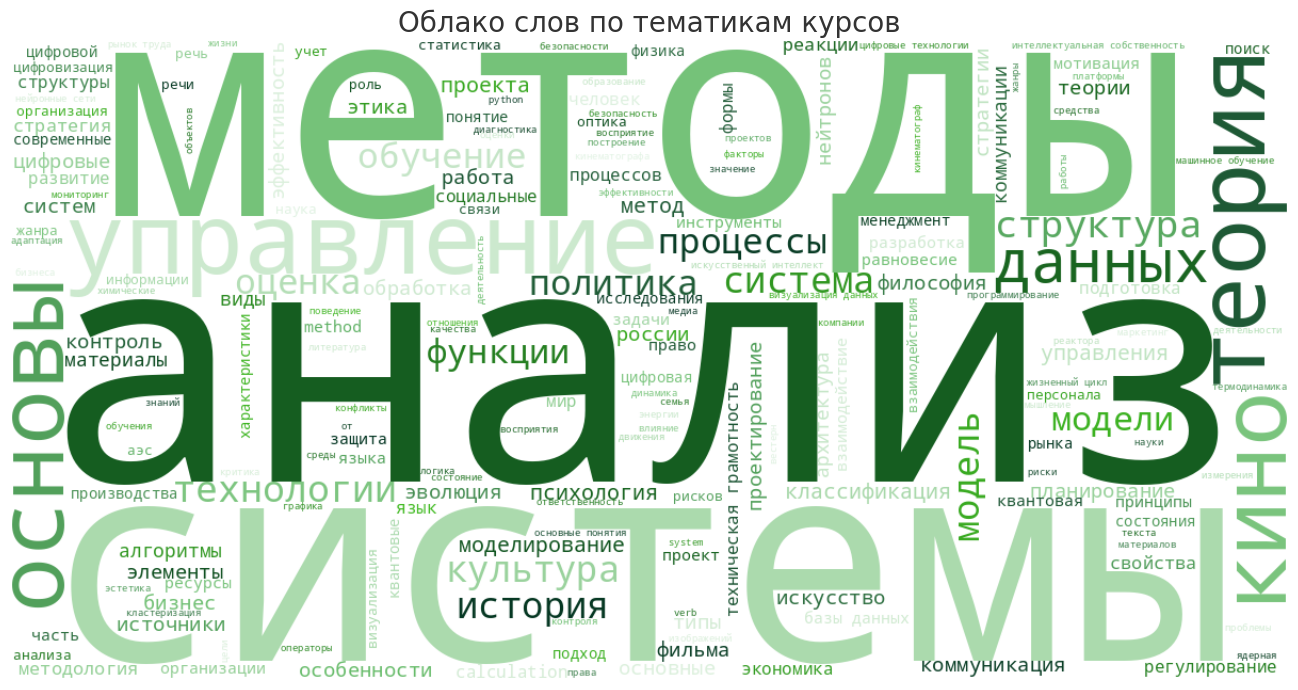

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Собираем все тексты из столбца syllabus
all_syllabus_text = ' '.join(df['syllabus'].dropna().str.lower())

# Определяем пользовательские стоп-слова
custom_stopwords = {'и', 'в', 'на', 'как', 'для', 'по', 'их', 'с', 'при', 'к', 'о'}

# Удаляем стоп-слова
words_filtered = ' '.join(
    word for word in all_syllabus_text.split() if word not in custom_stopwords
)

# Создаем кастомную палитру с контрастными зелеными оттенками
green_palette = [
    '#E8F5E9',  # светлый
    '#66BB6A',  # средний
    '#013220',  # темный
    '#40BA21'   # самый темный
]


# Генерируем облако слов с контрастной палитрой
wordcloud_filtered = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap=LinearSegmentedColormap.from_list('green_palette', green_palette),
    max_words=200,
    contour_width=1,
    contour_color='#333333',
    prefer_horizontal=0.9,
    relative_scaling=0.5
).generate(words_filtered)

# Отображаем облако
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud_filtered, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов по тематикам курсов',
          fontsize=20,
          # fontfamily='Times New Roman',
          color='#333333')
plt.tight_layout()
# plt.savefig('wordcloud_green_contrast.png', dpi=300, bbox_inches='tight')
plt.show()

Много вводных курсов и курсов, состоящих из нескольких частей

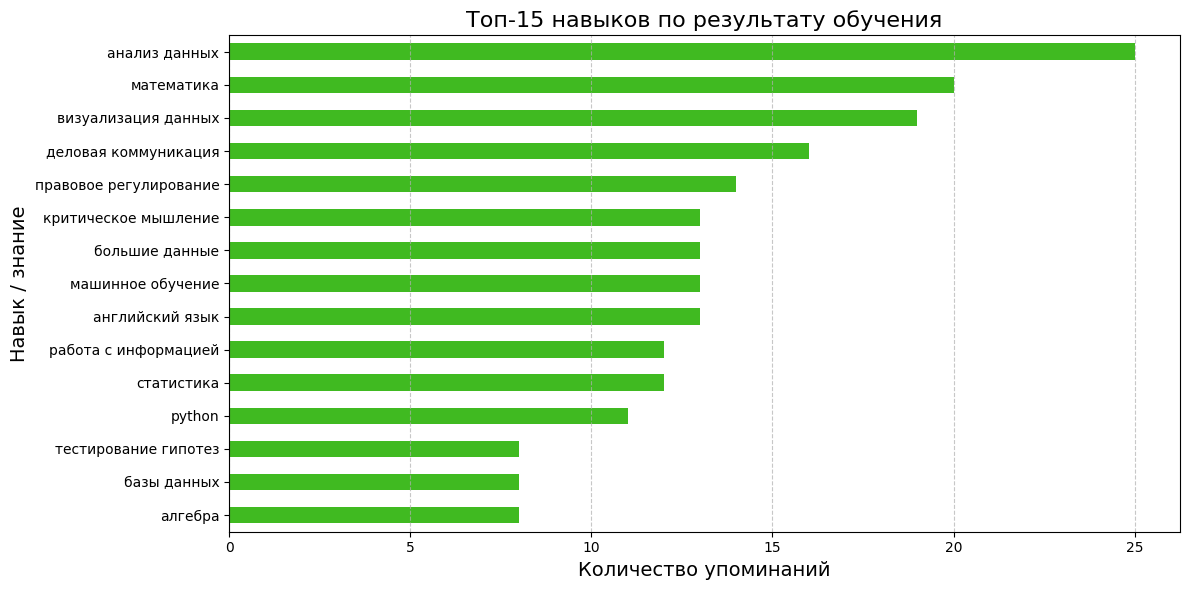

In [ ]:
from collections import Counter

# Очистка и анализ result_knowledge
knowledge_series = (
    df['result_knowledge']
    .dropna()
    .str.lower()
    .str.split(';')
    .explode()
    .str.strip()
)
# Исключаем "нет данных" и пустое
knowledge_series = knowledge_series[~knowledge_series.isin(['нет данных', '', 'n/a'])]

top_knowledge = pd.Series(Counter(knowledge_series)).sort_values(ascending=False).head(15)

# Визуализация
plt.figure(figsize=(12, 6))
top_knowledge.plot(kind='barh', color='#40BA21')  # Только заменил цвет здесь
plt.title('Топ-15 навыков по результату обучения', fontsize=16)
plt.xlabel('Количество упоминаний', fontsize=14)
plt.ylabel('Навык / знание', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

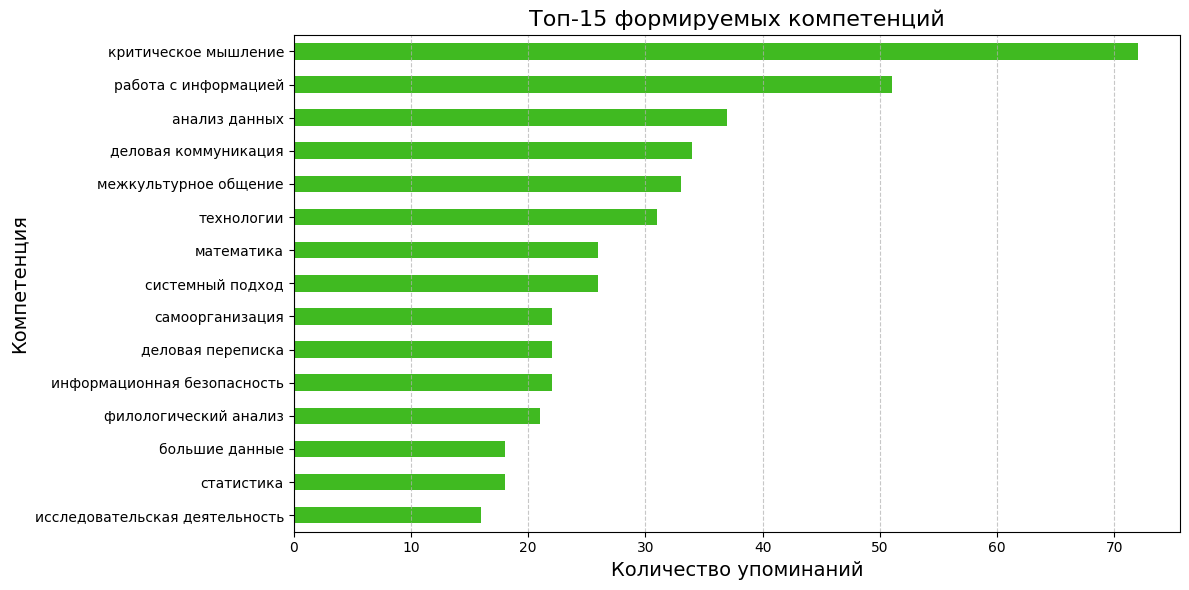

In [ ]:
# Очистка и анализ competence
competence_series = (
    df['competence']
    .dropna()
    .str.lower()
    .str.split(';')
    .explode()
    .str.strip()
)
# Удаление "нет данных" и пустых строк
competence_series = competence_series[~competence_series.isin(['нет данных', '', 'n/a'])]

top_competences = pd.Series(Counter(competence_series)).sort_values(ascending=False).head(15)

# Визуализация
plt.figure(figsize=(12, 6))
top_competences.plot(kind='barh', color='#40BA21')
plt.title('Топ-15 формируемых компетенций', fontsize=16)
plt.xlabel('Количество упоминаний', fontsize=14)
plt.ylabel('Компетенция', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Функция для извлечения кодов с названиями
def extract_codes(text):
    if pd.isna(text):
        return []

    # Ищем все соответствия кодам и последующий текст
    matches = re.finditer(r'(\d{2}\.\d{2}\.\d{2})\s*([^\d]+)', str(text))
    return [(m.group(1), m.group(2).strip()) for m in matches]

# Создаем список всех кодов с названиями
code_name_pairs = []
for groups in df['groups'].dropna():
    pairs = extract_codes(groups)
    code_name_pairs.extend(pairs)

# Создаем DataFrame с кодами и названиями
codes_df = pd.DataFrame(code_name_pairs, columns=['Код', 'Название'])

# Удаляем дубликаты (один код - одно название)
unique_codes = codes_df.drop_duplicates(subset=['Код'])

# Подсчитываем частоту кодов
code_counts = Counter([pair[0] for pair in code_name_pairs])

# Объединяем с частотностью
result_df = pd.DataFrame.from_dict(code_counts, orient='index', columns=['Количество курсов'])
result_df = result_df.merge(unique_codes.set_index('Код'), left_index=True, right_index=True)
result_df = result_df.sort_values('Количество курсов', ascending=False)

print("Топ-20 направлений подготовки:")
display(result_df.head(20).style.background_gradient(cmap='Blues', subset=['Количество курсов']))

Топ-20 направлений подготовки:


<ipython-input-129-650836844ec2>:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

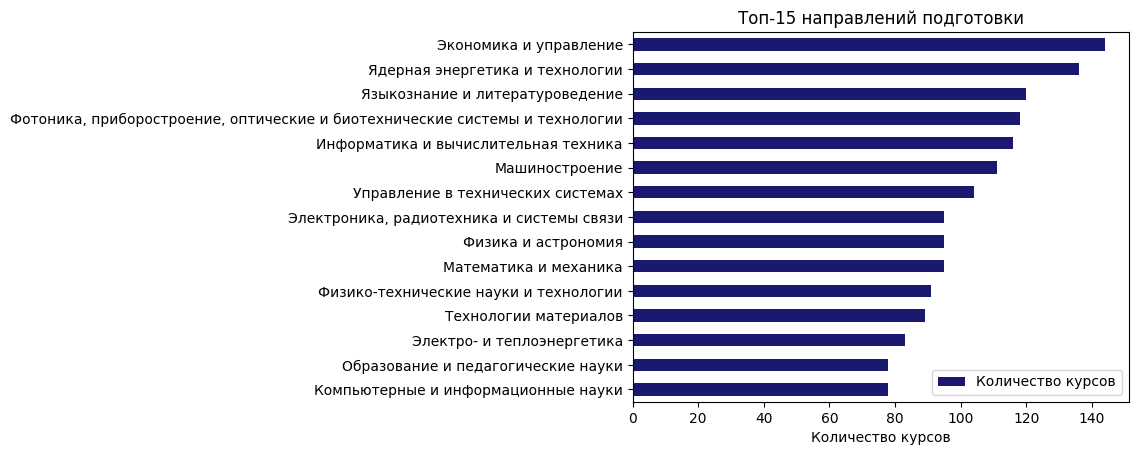

In [ ]:
# Визуализация
plt.figure(figsize=(12, 8))
result_df.head(15).sort_values('Количество курсов').plot(
    kind='barh',
    x='Название',
    y='Количество курсов',
    color='midnightblue',
    title='Топ-15 направлений подготовки'
)
plt.xlabel('Количество курсов')
plt.ylabel('')
plt.tight_layout()
plt.show()

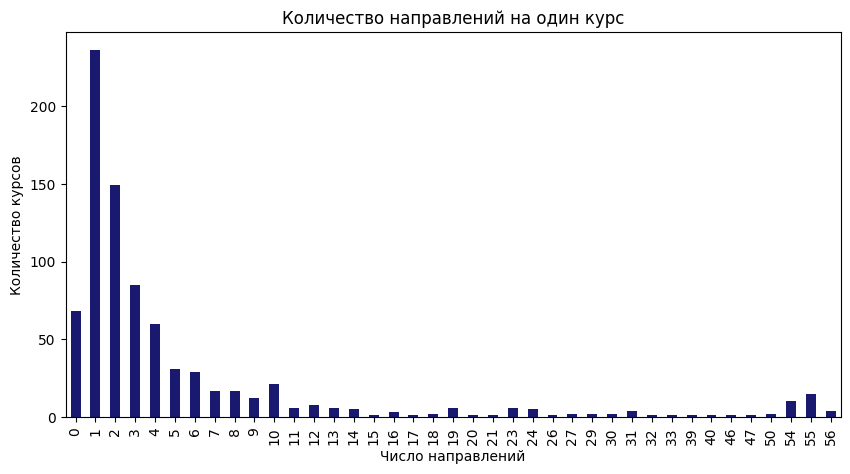

In [ ]:
# Анализ распределения количества направлений на курс
plt.figure(figsize=(10, 5))
df['groups'].dropna().apply(lambda x: len(extract_codes(x))).value_counts().sort_index().plot(
    kind='bar',
    color='midnightblue',
    title='Количество направлений на один курс'
)
plt.xlabel('Число направлений')
plt.ylabel('Количество курсов')
plt.show()

Для некоторых курсов перечисленно очень много направлений подготовки

In [ ]:
df.to_csv('cleaned_MOOC.csv', index=False)

тут несколько файлов, потому что я пробовала разное и пробовала долго. Для гпт потом выделяла отдельные строки и после этого объединяла с исходным обработанным датасетом

In [ ]:
import pandas as pd

df1=pd.read_csv('mooc_merged.csv')
df=pd.read_csv('mooc_final.csv')
df1.head(3)

Unnamed: 0                           title  \
0           0  Алгоритмы и структуры данных-1   
1           1  Алгоритмы и структуры данных-2   
2           2   Основания алгебры и геометрии   

                                                link  \
0  https://openedu.ru/course/hse/ADS_1/?session=2023   
1  https://openedu.ru/course/hse/ADS_2/?session=2023   
2  https://openedu.ru/course/hse/AGBASE/?session=...   

                                         description  \
0  Курс "Алгоритмы и структуры данных-1" посвящен...   
1  Курс "Алгоритмы и структуры данных-2" рассчита...   
2  Не секрет, что в школах учат одной математике,...   

                                        about_course  \
0  Пройдя курс, вы научитесь решать задачи, котор...   
1  Пройдя курс, вы расширите ваш багаж знаний по ...   
2  Онлайн-курс от НИУ ВШЭ позволит изучить все те...   

                                       course_format  \
0  Курс состоит из 7 недель. Каждая неделя содерж...   
1  Курс состоит из 7 недель. Каждая неделя содерж...   
2  Курс состоит из коротких видеолекций от 7 до 1...   

                                            syllabus  \
0  Сложность, тестирование, особые случаи; Линейн...   
1  Стек, очередь, дек; Динамическое программирова...   
2  Натуральные числа; Принцип математической инду...   

                                    result_knowledge  \
0  Студенты освоят и смогут применять на практике...   
1  Студенты расширят свои знания по наиболее вост...   
2  Натуральные числа; системы счисления, аксиомы ...   

                                          competence  \
0  Осознает сущность и значение информации в разв...   
1  Осознает сущность и значение информации в разв...   
2  Умение математически строго аргументировать св...   

                                              groups  \
0  01.03.00 Математика. Компьютерные науки09.03.0...   
1  01.03.00 Математика. Компьютерные науки09.03.0...   
2  Курс предназначен для всех направлений подгото...   

                          title.1  \
0  Алгоритмы и структуры данных-1   
1  Алгоритмы и структуры данных-2   
2   Основания алгебры и геометрии   

                                          syllabus.1  \
0  линейный поиск; множества; словари и сортировк...   
1  структуры данных: стек, очередь, дек; методы д...   
2  натуральные числа и индукция; логика и теория ...   

                                 result_knowledge.1  \
0                      алгоритмы и структуры данных   
1           применение алгоритмов и структур данных   
2  решение математических задач; алгебра; геометрия   

                                        competence.1  
0  хранение и переработка информации; построение ...  
1       разработка алгоритмов; анализ научных данных  
2  математическая аргументация; работа с математи...

In [ ]:
df1 = df1.drop(columns=['Unnamed: 0', 'syllabus','result_knowledge','competence','title.1','syllabus.1','result_knowledge.1','competence.1'])
df1.head(3)

title  \
0  Алгоритмы и структуры данных-1   
1  Алгоритмы и структуры данных-2   
2   Основания алгебры и геометрии   

                                                link  \
0  https://openedu.ru/course/hse/ADS_1/?session=2023   
1  https://openedu.ru/course/hse/ADS_2/?session=2023   
2  https://openedu.ru/course/hse/AGBASE/?session=...   

                                         description  \
0  Курс "Алгоритмы и структуры данных-1" посвящен...   
1  Курс "Алгоритмы и структуры данных-2" рассчита...   
2  Не секрет, что в школах учат одной математике,...   

                                        about_course  \
0  Пройдя курс, вы научитесь решать задачи, котор...   
1  Пройдя курс, вы расширите ваш багаж знаний по ...   
2  Онлайн-курс от НИУ ВШЭ позволит изучить все те...   

                                       course_format  \
0  Курс состоит из 7 недель. Каждая неделя содерж...   
1  Курс состоит из 7 недель. Каждая неделя содерж...   
2  Курс состоит из коротких видеолекций от 7 до 1...   

                                              groups  
0  01.03.00 Математика. Компьютерные науки09.03.0...  
1  01.03.00 Математика. Компьютерные науки09.03.0...  
2  Курс предназначен для всех направлений подгото...

In [ ]:
import re

def normalize_edu_text(text):
    """Функция для нормализации текста в образовательных данных"""
    if pd.isna(text):
        return ""

    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление спецсимволов, кроме точек с запятой
    text = re.sub(r"[_:()\-]", " ", text)
    text = re.sub(r"[^a-zа-яё0-9\s.,;]", "", text)
    # Замена множественных пробелов на один
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def process_edu_semilist(text):
    """Обработка списков в образовательных данных"""
    if pd.isna(text) or not text:
        return ""

    # Нормализация текста
    text = normalize_edu_text(text)

    # Разделение элементов
    items = [item.strip() for item in text.split(';')]

    # Очистка каждого элемента
    processed_items = []
    for item in items:
        if not item:
            continue

        # Удаление лишних символов
        item = re.sub(r"[^a-zа-яё0-9\s/-]", "", item)
        item = item.strip(" ,.-")

        if item:
            processed_items.append(item)

    # Удаление дубликатов с сохранением порядка
    seen = set()
    unique_items = []
    for item in processed_items:
        if item not in seen:
            seen.add(item)
            unique_items.append(item)

    return "; ".join(unique_items)

# Применяем обработку к нужным колонкам
df["syllabus"] = df["syllabus"].apply(process_edu_semilist)
df["competence"] = df["competence"].apply(process_edu_semilist)
df["result_knowledge"] = df["result_knowledge"].apply(process_edu_semilist)

# df

In [ ]:
gpt_df=df1[['title','syllabus','result_knowledge','competence']].copy()

In [ ]:
gpt_df

title  \
0                       Алгоритмы и структуры данных-1   
1                       Алгоритмы и структуры данных-2   
2                        Основания алгебры и геометрии   
3            Анализ инвестиционных проектов и программ   
4           Арабский мир: история, политика, экономика   
..                                                 ...   
819          Беспроводные телекоммуникационные системы   
820                                       Теплотехника   
821              Теория решения изобретательских задач   
822  Теория вероятностей и математическая статистик...   
823  Строительные технологии на основе хризотилцеме...   

                                              syllabus  \
0    сложность тестирование особые случаи; линейный...   
1    стек очередь дек; динамическое программировани...   
2    натуральные числа; принцип математической инду...   
3    основные игроки на рынке реального инвестирова...   
4    появление арабских стран на политической карте...   
..                                                 ...   
819  беспроводная передача информации; модели канал...   
820  техническая термодинамика; основные понятия и ...   
821  курс состоит из пятнадцати разделов и начинает...   
822  случайные события в теории вероятностей; элеме...   
823  общие сведения о хризотилцементе; определение ...   

                                      result_knowledge  \
0    студенты освоят и смогут применять на практике...   
1    студенты расширят свои знания по наиболее вост...   
2    натуральные числа; системы счисления аксиомы п...   
3    после завершения этого курса слушатели сумеют ...   
4    слушатели курса смогут оценивать политические ...   
..                                                 ...   
819  изложить основные принципы построения и функци...   
820  объяснять законы и закономерности термодинамик...   
821  в результате освоения курса триз обучающийся б...   
822  после освоения курса обучающийся будет способе...   
823  формулировать прикладные задачи по проектирова...   

                                            competence  
0    осознает сущность и значение информации в разв...  
1    осознает сущность и значение информации в разв...  
2    умение математически строго аргументировать св...  
3    способность осуществлять сбор анализ и обработ...  
4    способен осуществлять поиск критическии анализ...  
..                                                 ...  
819  способен спроектировать и исследовать электрон...  
820  способность моделировать энерго и ресурсосбере...  
821  в процессе освоения дисциплины у студентов раз...  
822  способность использовать основные приемы обраб...  
823  способность разрабатывать проектную и рабочую ...  

[824 rows x 4 columns]

In [ ]:
gpt_df10=gpt_df.copy()

In [ ]:
gpt_df.to_csv('gpt_df.csv')

In [ ]:
gpt_df.to_json('output.json', orient='records', force_ascii=False, indent=4)

In [ ]:
prompt= """
You are an algorithm designed for extracting skills from text format
You will be provided with the text entitled "syllabus:","result_knowledge:","competence:".
You are expected to output only the list of identified key skills that a student may gain after taking some online course.
For syllabus you should NOT shorten or paraphrase text,
you should only remove introductory words or correct errors.
Terms in syllabus and result_knowledge should NOT be repeated.

Key rules:
1. Extract ONLY concrete skills (avoid verbs like "демонстрировать", "определять","способен")
2. Combine related terms into single skills
3. Keep skills concise (2-4 words max)

Here are a few examples of input texts and expected output for each of them:

<example>
Input:
[
    {
        "title":"Логика",
        "syllabus":"классическая логика высказываний; синтаксис семантика; законы; дизъюнктивные и конъюнктивные нормальные формы; исчисление секвенций; интуиционистская логика высказываний; семантика крипке; классическая логика предикатов; сигнатура модели сигнатуры; определимость; префиксная нормальная форма; теории первого порядка; свойства теорий; алгоритмы; разрешимость; теорема чёрча; модальные логики; синтаксис семантика крипке; исчисления; теоремы о полноте; связь с интуиционистской логикой и логикой предикатов",
        "result_knowledge":"предполагается что в результате освоения дисциплины слушатели будут; владеть основными понятиями теории множеств; владеть основными методами преобразования логических выражений; уметь записывать содержательные математические утверждения в языке логики предикатов; владеть методами доказательства теорем в исчислениях высказываний и предикатов; уметь строить модели формул и теорий первого порядка; иметь представление о месте математической логики в системе научного знания; знать важные содержательные результаты полученные в рамках математической логики",
        "competence":"способен осуществлять поиск критический анализ и синтез информации применять системный подход для решения поставленных задач"
    },
    {
        "title":"Прикладной статистический анализ",
        "syllabus":"базовые понятия и задачи статистики; сведения из теории вероятностей для построения статистических моделей; оценивание параметров в практике статистического анализа; статистическая проверка гипотез и ее приложения; характеристики многомерной совокупности; меры взаимосвязи признаков; регрессионный анализ элементы теории и практические приложения; параметрическое и непараметрическое моделирования распределений; выделение однородных групп объектов методами классификации; снижение размерности признакового пространства и построение индексов; модели временных рядов и их применение",
        "result_knowledge":"способен осуществлять сбор анализ и обработку статистических данных информации научно аналитических материалов необходимых для решения поставленных задач; способен выбрать инструментальные средства для обработки данных в соответствии с поставленной задачей проанализировать результаты расчетов и обосновать полученные выводы",
        "competence":"способен на основе описания процессов и явлений строить теоретические и эконометрические модели анализировать и содержательно интерпретировать полученные результаты; способен использовать для решения аналитических и исследовательских задач современные технические средства и информационные технологии"
    },
    {
        "title":"Статистика для анализа данных",
        "syllabus":"в статистику и работа с данными; генеральная совокупность и выборка; частоты; распределения; описательные статистики меры центральной тенденции и разброса; z распределение и его свойства; корреляция; визуализация данных часть 1; повторение; визуализация данных часть 2; в статистику выводов постановка гипотез; применение параметрических критериев; непараметрические тесты; линейная регрессия; логистическая регрессия",
        "result_knowledge":"слушатель знает основные понятия статистики и умеет ими оперировать; слушатель умеет загружать и исследовать данные в выбранном по; слушатель умеет проводить описательный анализ данных; слушатель умеет выбирать корректный тип визуализации и визуализировать данные; слушатель умеет определять тип распределения по визуализации и интерпретировать его; слушатель умеет определять силу и направление корреляции по коэффициенту и визуализации; умеет интерпретировать корреляцию в данных; слушатель умеет построить линейный тренд в данных и интерпретировать его уравнение; слушатель умеет поставить гипотезу выбрать критерий значимости и корректный параметрический или непараметрический тест для проверки гипотезы; слушатель умеет рассчитать и интерпретировать критерий стьюдента для разных выборок; слушатель умеет применять к данным модель линейной регрессии и интерпретировать ее метрики и коэффициенты; умеет проверить ограничения и допущения для построения такой модели; слушатель умеет применять к данным модель логистической регрессии и интерпретировать ее метрики и коэффициенты",
        "competence":"способность самостоятельно осуществлять постановку задачи статистического анализа и оценивания в избранной предметной области выбор и применение статистического инструментария и программных средств; способность самостоятельно осваивать новые методы прикладной и математической статистики для их использования в аналитической работе; способность осознанно применять методы математической и дескриптивной статистики для анализа количественных данных содержательно интерпретировать результаты; способен вести исследовательскую деятельность включая анализ проблем постановку целей и задач выделение объекта и предмета исследования выбор способа и методов исследования а также оценку его качества"
    },
]

Output:
[
    {
        "title":"Логика",
        "syllabus":"классическая логика высказываний; синтаксис семантики; законы; дизъюнктивные и конъюнктивные нормальные формы; исчисление секвенций; интуиционистская логика высказываний; семантика крипке; классическая логика предикатов; сигнатура модели сигнатуры; определимость; префиксная нормальная форма; теории первого порядка; свойства теорий; алгоритмы; разрешимость; теорема чёрча; модальные логики; синтаксис семантика крипке; исчисления; теоремы о полноте; связь с интуиционистской логикой и логикой предикатов",
        "result_knowledge":
        "теория множеств;
        методы преобразования логических выражений;
        модели формул и теорий первого порядка;
        математическая логика,
        "competence":"критический анализ;
         системный подход для решения задач;
         логическое мышление;
         логика в математике"
    },
    {
        "title":"Прикладной статистический анализ",
        "syllabus":"базовые понятия и задачи статистики;
        сведения из теории вероятностей для построения статистических моделей;
        оценивание параметров в практике статистического анализа;
        статистическая проверка гипотез и ее приложения;
        характеристики многомерной совокупности;
        меры взаимосвязи признаков;
        регрессионный анализ элементы теории и практические приложения;
        параметрическое и непараметрическое моделирования распределений;
        выделение однородных групп объектов методами классификации;
        снижение размерности признакового пространства и построение индексов;
        модели временных рядов и их применение",
        "result_knowledge":
        "работа с данными;
        обработка данных;
        анализ результатов,
         "competence":
        "теоретические и эконометрические модели;
         математическая статистика;
         теория вероятностей;
         проверка гипотез;
         временные ряды;
         анализ данных"
    },
    {
        "title":"Статистика для анализа данных",
        "syllabus":"генеральная совокупность и выборка;
        частоты; распределения;
        описательные статистики меры центральной тенденции и разброса;
        z распределение и его свойства; корреляция; визуализация данных часть 1;
        повторение; визуализация данных часть 2; в статистику выводов постановка гипотез;
        применение параметрических критериев;
        непараметрические тесты;
        линейная регрессия;
        логистическая регрессия",
        "result_knowledge":
        "статистика;
        работа с данными;
        описательный анализ данных;
        визуализация данных;
        корреляция в данных;
        линейные тренды;
        интерпретация данных;
        проверка гипотез;
        параметрические и непараметрические тесты;
        критерий стьюдента;
        линейная регрессия;
        метрики;
        логистическая регрессия,
        "competence":
        "математическая статистика;
        прикладная статистика;
        анализ данных;
        интерпретация результатов;
        анализ проблем;
        постановка целей и задач;
        выбор способа и методов исследования;
        оценка качества модели"
    },
]

"""

In [ ]:
"""
You are a text standardization algorithm specialized in skill ontology development.
Your task is to process json file containing online courses data to create a unified competency dictionary.

Input:
- CSV file with columns: result knowledge, competence
- Text data contains mixed Russian/English terms with varying formulations

Processing steps:
1. EXTRACTION:
   - Parse all text from the three target columns
   - Split compound entries (separated by ';' and /) into individual terms
   - Remove stopwords but preserve technical terms

2. NORMALIZATION:
   - Convert all terms to lowercase
   - Remove punctuation except special characters needed for technical terms (like 'C++')
   - Handle both Russian and English terms appropriately

4. TERM CLUSTERING:
   - Group terms by conceptual similarity using these rules:
     a) Spelling variations (incl. typos)
     b) Abbreviations/short forms
     c) Linguistic variants (active/passive voice)
     d) Technical synonyms
     e) Tool-specific implementations
e.g. "ab тестирование", "bayesian a/b тестирование" and "ab тесты" is one concept,
canonical will bw "ab тесты",
"bi": [
      "bi",
      "bi аналитика",
      "bi инструменты",
      "bi инструментарий",
      "bi отчетность",
      "bi отчеты",
      "bi платформы",
      "bi решения",
      "bi система",
      "bi системы",
      "business intelligence",
      "business intelligence systems"]
      is the same concept as "power bi" and "bi tools"


3. STANDARDIZATION:
   For each unique concept identified:
   a) Create a dictionary entry where:
      - KEY: Most canonical formulation (prioritize:
        1. Industry-standard terms
        2. Most frequent formulation
        3. Most precise and short technical term)
      - VALUE: List of all alternative formulations found

   b) Special cases:
      - Map different programming language versions to base form (Python 3 → Python)
      - Standardize tool names (ms sql → sql)
      - Normalize skill levels (Basic knowledge of python. → python)

5. OUTPUT:
   - Produce 2 dictionaries. One with frequency count, order by frequency.
   The second one - common dictionary lower case of all concepts from the file.
   The second one should show FULL JSON!

Format requirements:
- Use JSON structure
- Preserve Russian language for terms, except the special terms and abbriviations in english
(e.g. keep "машинное обучение" instead of "machine learning" but "python" instead of "питон")
- Preserve the lower case
- Include frequency counts for variants
- Flag ambiguous terms for human review

Example transformation:
Input:
"знание Excel; Google Sheets; анализ данных; python; теорвер; a/b тестирование;
etl запросы; язык программирования c; ml; bi системы; знание sql; мат стат",

"ms excel; знание python; теор вер; статистика; bi; sql запросы; статистика;
ad hock аналитика; a/b тесты; поведение пользователей; c; dwh; greenplum; проектное управление"

"python language; power bi; sql (опыт); реляционные бд; математическая статистика; adhoc;
a/b тесты; анализ пользовательского поведения; c++; продуктовые стратегии; unit экономика; дашборды"

"postgresql; субд; математическая статистика; ad hoc; a/b тестирование; анализ поведения пользователей;
портфель продуктов; продуктовая аналитика; тз; документация"

Output: {
  "excel": ["excel", "google sheets", "ms excel"],
  "анализ данных": ["анализ данных", "data analysis","аналитика данныъ"],
  "python": ["знание python", "python language],
  "теория вероятности":["теорвер", "теор вер"],
  "power bi":["bi","bi системы","power bi"],
  "sql":["знание sql","sql (...)", "ms sql","postgresql","субд","субд и хранилища данных",
  "реляционные бд", "бд","б.д."],
  "математическая статистика":["математическая статистика", "статистика","мат стат",
  "мат. стат", "statistics"],
  "ad hoc":["ad hoc", "ad hoc analysis", "ad hock", "adhock аналитика", "adhoc аналитика",
  "adhock","adhoc"],
  "a/b тесты":["a/b тесты", "провередние a/b тестов", "a/b тестирование", "опыт a/b тестов",
  "a/b"],
  "etl":["etl","etl запросы"],
  "c++":["c++", "язык программирования c++", "язык программирования c", "c","c+","язык c",
  "язык c++", "программирование c++"],
  "тестирование гипотез":["тестирование гипотез", "гипотезы", "проверка гипотез"],
  "поведение пользователей":["поведение пользователей", "анализ поведения пользователей", "пользовательское поведение"],
  "машинное обучение":["машинное обучение","ml","machine learning", "mlops"],
  "рекомендательные системы":["рекомендательные системы","система рекомендаций", "рекомендации",
  "recsys", "recommender systems", "recommendation systems"],
  "временные ряды":["временные ряды","анализ временных рядов"],
  "kubernetes":["kubernetes","k8s"],
  "продуктовая аналитика":["продуктовая аналитика"],
  "unit экономика":["unit экономика"],
  "проектное управление":["проектное управление]

  etc...
}
"""

In [ ]:
import json
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Загрузка данных
with open('mooc_gpt.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
data

[{'title': 'Алгоритмы и структуры данных-1',
  'syllabus': 'линейный поиск; множества; словари и сортировка подсчетом; префиксные суммы и два указателя; бинарный поиск; сортировка событий',
  'result_knowledge': 'алгоритмы и структуры данных',
  'competence': 'хранение и переработка информации; построение математической модели; анализ научных данных'},
 {'title': 'Алгоритмы и структуры данных-2',
  'syllabus': 'структуры данных: стек, очередь, дек; методы динамического программирования; методы рекурсивных переборов; алгоритмы обхода графов в ширину и в глубину; структуры деревьев и деревья поиска',
  'result_knowledge': 'применение алгоритмов и структур данных',
  'competence': 'разработка алгоритмов; анализ научных данных'},
 {'title': 'Основания алгебры и геометрии',
  'syllabus': 'натуральные числа и индукция; логика и теория множеств; свойства делимости и цепные дроби; комплексные числа; построения циркулем и линейкой; евклидова и неевклидова геометрия; аксиомы Гильберта; векторные

In [ ]:
!pip install -q faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import pprint

# Собираем все навыки
all_skills = []
for module in data:
    for key in ['result_knowledge', 'competence']:
        if key in module:
            all_skills.extend([s.strip() for s in module[key].split(';')])

# Удаляем дубликаты
unique_skills = list(set(all_skills))

print(f"Всего уникальных навыков: {len(unique_skills)}")

# Модель
model = SentenceTransformer("thenlper/gte-large")

# Создаем эмбеддинги
skill_embeddings = model.encode(unique_skills, normalize_embeddings=True)

# Индекс FAISS
index = faiss.IndexFlatIP(skill_embeddings.shape[1])
index.add(skill_embeddings)

# Поиск похожих навыков
similar_skills_dict = {}

for i, skill in enumerate(unique_skills):
    query = skill_embeddings[i].reshape(1, -1)
    D, I = index.search(query, 6)  # 1 — сам навык, остальные — похожие
    top_skills = [unique_skills[j] for j in I[0] if j != i][:5]
    similar_skills_dict[skill] = top_skills

pprint.pprint(list(similar_skills_dict.items())[:5])


Всего уникальных навыков: 4128


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

[('моделирование данных',
  ['прогнозирование данных',
   'инженерия данных',
   'компьютерное моделирование',
   'численное моделирование',
   'классификация данных']),
 ('',
  ['геометрия',
   'импринтинг',
   'биопринтинг',
   'коммуникация',
   'анализ макропроцессов']),
 ('бизнес-планирование',
  ['бизнес-моделирование',
   'анализ и создание бизнес-плана',
   'знание бизнес-процессов',
   'оптимизация бизнес-процессов',
   'бизнес планирование']),
 ('циклы времени компиляции',
  ['цифровые коммуникации',
   'цифровая коммуникация',
   'цифровое управление',
   'цифровая трансформация',
   'цифровая медицинская грамотность']),
 ('толерантность к культурным различиям',
  ['знание исторических типов культуры и русской культурной традиции',
   'культурные традиции',
   'культурные различия в питании',
   'сравнение политических культур',
   'культурная политика'])]


In [ ]:
import json

with open("similar_skills.json", "w", encoding="utf-8") as f:
    json.dump(similar_skills_dict, f, ensure_ascii=False, indent=2)

In [ ]:
from sentence_transformers import util

# словарь
filtered_similar_skills = {}

for i, skill in enumerate(unique_skills):
    query_embedding = skill_embeddings[i].reshape(1, -1)
    D, I = index.search(query_embedding, 6)  # 6 ближайших (включая самого себя)

    filtered = []
    for j in I[0]:
        if j == i:
            continue  # пропускаем сам навык
        candidate = unique_skills[j]
        score = float(util.cos_sim(skill_embeddings[i], skill_embeddings[j]))
        if score >= 0.93:
            filtered.append((candidate, round(score, 3)))

    if filtered:
        filtered_similar_skills[skill] = filtered

for skill, matches in list(filtered_similar_skills.items())[:15]:
    print(f"\n🔹 {skill}")
    for match, score in matches:
        print(f"   → {match} (сходство: {score})")



🔹 анализ театральных событий
   → анализ рекламных сообщений (сходство: 0.949)
   → анализ проблемных ситуаций (сходство: 0.945)
   → аналитические работы (сходство: 0.942)
   → понимание театральности (сходство: 0.941)
   → сопоставительный анализ (сходство: 0.94)

🔹 менеджмент качества
   → принципы менеджмента качества (сходство: 0.943)
   → методы качественного управления (сходство: 0.935)
   → управление качеством (сходство: 0.931)

🔹 chinese phonetics
   → Chinese pronunciation (сходство: 0.947)

🔹 дефектоскопия
   → дефектология (сходство: 0.942)
   → электронная микроскопия (сходство: 0.941)

🔹 история цивилизаций
   → культура и экономика цивилизаций (сходство: 0.942)
   → технологии цифрового образования (сходство: 0.932)
   → технологии цифровизации (сходство: 0.931)
   → цифровизация в организациях (сходство: 0.93)

🔹 масштабирование нейросетей
   → методы обучения нейросетей (сходство: 0.945)
   → тестирование мобильных приложений (сходство: 0.936)
   → моделирование нели

In [ ]:
"""
In the previous step, we extracted raw competences from 3 sourses of data - vacancies, online courses, education program
by developing dictionaries for each of the seperately.
Your task now is to create unified normalized dictionary for the terms to maintain consistent terminology
and make it easier to use semantic simmilarity on graph.
You are provided with 3 dictionaries with competencies where the key is
Your task is to replace each extracted skill with the most appropriate **canonical skill name** from the list provided.
Choose the closest match in meaning. If there is no suitable match, return the original skill.
Be carefull, there is quite often no good synonim for concrete skill.
Imagine that you will use prepared canonical skill names for making a recommendation based on semantic simmilarity
in graphs for 3 types of data.

Your task is to:
1. Group synonymous terms (e.g. "машинное обучение" and "ML алгоритмы", "c" and "с++" and "язык программирования c",
"менеджмент качества" and "принципы менеджмента качества")
2. Select the most canonical form for each skill.
3. Keep only domain-relevant terms (remove generic verbs)
4. Try not to repeat one skill within one module name if you change the canonical skill name
(e.g. there was mentioned "python" and "python продвинутый уровень", keep only "python")

Return the updated JSON file. Show examples of your changes in the chat

In [ ]:
df = pd.DataFrame(data)
df

title  \
0                       Алгоритмы и структуры данных-1   
1                       Алгоритмы и структуры данных-2   
2                        Основания алгебры и геометрии   
3            Анализ инвестиционных проектов и программ   
4           Арабский мир: история, политика, экономика   
..                                                 ...   
819          Беспроводные телекоммуникационные системы   
820                                       Теплотехника   
821              Теория решения изобретательских задач   
822  Теория вероятностей и математическая статистик...   
823  Строительные технологии на основе хризотилцеме...   

                                              syllabus  \
0    линейный поиск; множества; словари и сортировк...   
1    структуры данных: стек, очередь, дек; методы д...   
2    натуральные числа и индукция; логика и теория ...   
3    структура рынка инвестирования; анализ инвести...   
4    появление арабских стран на политической карте...   
..                                                 ...   
819  беспроводная связь; каналы связи; радиопередат...   
820  термодинамика; теплопередача; теплопроводность...   
821  инновации; системный оператор; идеальность; пр...   
822  случайные события; комбинаторика; распределени...   
823  хризотилцемент; производство изделий; строител...   

                                      result_knowledge  \
0                         алгоритмы и структуры данных   
1              применение алгоритмов и структур данных   
2     решение математических задач; алгебра; геометрия   
3    оценка инвестиционной привлекательности; постр...   
4    анализ политических и экономических процессов;...   
..                                                 ...   
819  беспроводные системы; спектральный анализ; мод...   
820  расчеты тепловых процессов; термодинамические ...   
821  анализ проблемных ситуаций; устранение противо...   
822  теория вероятностей; проверка гипотез; линейна...   
823  строительство с хризотилцементом; проектная до...   

                                            competence  
0    хранение и переработка информации; построение ...  
1         разработка алгоритмов; анализ научных данных  
2    математическая аргументация; работа с математи...  
3    анализ экономических данных; выбор инструменто...  
4    критический анализ; системный подход; межкульт...  
..                                                 ...  
819                  проектирование электронных систем  
820  энергосбережение; теплотехнические расчеты; мо...  
821  решение инженерных задач; инновационные подход...  
822  обработка экспериментальных данных; математиче...  
823  разработка проектной документации; нормативное...  

[824 rows x 4 columns]

data - после работы gpt модели

In [ ]:
# assert len(df1) == len(df)

# Объединение по индексу
df_merged = pd.concat([df1.reset_index(drop=True),
                       df.reset_index(drop=True)], axis=1)
df_merged

title  \
0                       Алгоритмы и структуры данных-1   
1                       Алгоритмы и структуры данных-2   
2                        Основания алгебры и геометрии   
3            Анализ инвестиционных проектов и программ   
4           Арабский мир: история, политика, экономика   
..                                                 ...   
819          Беспроводные телекоммуникационные системы   
820                                       Теплотехника   
821              Теория решения изобретательских задач   
822  Теория вероятностей и математическая статистик...   
823  Строительные технологии на основе хризотилцеме...   

                                                  link  \
0    https://openedu.ru/course/hse/ADS_1/?session=2023   
1    https://openedu.ru/course/hse/ADS_2/?session=2023   
2    https://openedu.ru/course/hse/AGBASE/?session=...   
3     https://openedu.ru/course/hse/AIPP/?session=2022   
4    https://openedu.ru/course/hse/ARABWORLD/?sessi...   
..                                                 ...   
819  https://openedu.ru/course/urfu/TELECOM/?sessio...   
820  https://openedu.ru/course/urfu/TEPL/?session=s...   
821  https://openedu.ru/course/urfu/TRIZ/?session=s...   
822  https://openedu.ru/course/urfu/TheorVer/?sessi...   
823  https://openedu.ru/course/urfu/chryso/?session...   

                                           description  \
0    Курс "Алгоритмы и структуры данных-1" посвящен...   
1    Курс "Алгоритмы и структуры данных-2" рассчита...   
2    Не секрет, что в школах учат одной математике,...   
3    В курсе изучаются основные приемы финансово-эк...   
4    В рамках стратегии «Поворот на Восток» возраст...   
..                                                 ...   
819                                         Нет данных   
820  ​В данном курсе излагаются основы технической ...   
821  Курс ориентирован на развитие умений пользоват...   
822  Целью изучения онлайн-курса является формирова...   
823  Курс «Строительные технологии на основе хризот...   

                                          about_course  \
0    Пройдя курс, вы научитесь решать задачи, котор...   
1    Пройдя курс, вы расширите ваш багаж знаний по ...   
2    Онлайн-курс от НИУ ВШЭ позволит изучить все те...   
3    Курс нацелен на развитие навыков применения фи...   
4    Курс направлен на формирование универсальных и...   
..                                                 ...   
819  Курс направлен на формирование представлений о...   
820  Теплотехника – комплексная научная дисциплина,...   
821  Содержание курса направлено на изучение основ ...   
822  Случай привносит в нашу жизнь и профессиональн...   
823  Курс «Строительные технологии на основе хризот...   

                                         course_format  \
0    Курс состоит из 7 недель. Каждая неделя содерж...   
1    Курс состоит из 7 недель. Каждая неделя содерж...   
2    Курс состоит из коротких видеолекций от 7 до 1...   
3    Курс состоит из 10 недель. Каждая неделя содер...   
4    Курс состоит из 7 недель. Каждая неделя содерж...   
..                                                 ...   
819  Еженедельные занятия будут включать просмотр в...   
820  Еженедельные занятия будут включать просмотр т...   
821  Еженедельно обучающимся предлагается изучить с...   
822  Структура курса включает:видеолекции с изложен...   
823  Разделы курса включают видеолекции, текстовые ...   

                                                groups  \
0    01.03.00 Математика. Компьютерные науки09.03.0...   
1    01.03.00 Математика. Компьютерные науки09.03.0...   
2    Курс предназначен для всех направлений подгото...   
3                      38.00.00 Экономика и управление   
4    08.02.00 Менеджмент38.03.01 Экономика41.03.01 ...   
..                                                 ...   
819  11.00.00 Электроника, радиотехника и системы с...   
820  08.00.00 Техника и технологии строительства14....   
821  05.00.00 Науки о земле07.00.00 Архите

In [ ]:
df_merged.to_csv('mooc_final_emb.csv')

In [ ]:
df_missing_updated = df_merged[
    df_merged['syllabus_updated'].isnull() & df_merged['syllabus'].notnull()
]
print(df_missing_updated[['title', 'syllabus']])


Empty DataFrame
Columns: [title, syllabus]
Index: []


In [ ]:
duplicates = df_merged[df_merged.duplicated('link', keep=False)]

# Сортировка по столбцу 'title' для удобства просмотра
duplicates_sorted = duplicates.sort_values(by='link')

# Вывод результата
duplicates_sorted

Empty DataFrame
Columns: [title, link, description, about_course, course_format, syllabus, result_knowledge, competence, groups, title, syllabus, result_knowledge, competence]
Index: []

# MOOC Embeddings

In [ ]:
# import json
# import pandas as pd

# # Загрузим файл (предположим, он уже есть в директории)
# with open('mooc_prepared_19_04.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# # Преобразуем в DataFrame
# df = pd.DataFrame(data)

In [ ]:
# df.head()

title  \
0              Алгоритмы и структуры данных-1   
1              Алгоритмы и структуры данных-2   
2               Основания алгебры и геометрии   
3   Анализ инвестиционных проектов и программ   
4  Арабский мир: история, политика, экономика   

                                            syllabus  \
0  линейный поиск; множества; словари и сортировк...   
1  структуры данных: стек, очередь, дек; методы д...   
2  натуральные числа и индукция; логика и теория ...   
3  структура рынка инвестирования; анализ инвести...   
4  появление арабских стран на политической карте...   

                                    result_knowledge  \
0                                      анализ данных   
1            применение алгоритмов и структур данных   
2                     математика; алгебра; геометрия   
3  оценка инвестиционной привлекательности; постр...   
4  анализ политических процессов; особенности вед...   

                                          competence  
0          большие данные; математика; анализ данных  
1               разработка алгоритмов; анализ данных  
2                                         математика  
3  анализ данных; большие данные; формирование от...  
4  критическое мышление; системный подход; межкул...

In [ ]:
# import pandas as pd
# import re
# from sentence_transformers import SentenceTransformer
# import numpy as np

# # Функции очистки текста
# def clean_text(text):
#     if pd.isna(text): return ""
#     text = re.sub(r'[^\w\s.,;!?]', '', str(text))
#     return text.strip()

# def split_semicolon(text):
#     if pd.isna(text): return []
#     return [clean_text(item) for item in str(text).split(';') if item.strip()]

# # Инициализация модели
# model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# # Обработка колонок с списками
# for col in ['syllabus', 'result_knowledge', 'competence']:
#     df[f'{col}_items'] = df[col].apply(split_semicolon)
#     df[f'{col}_embeddings'] = df[f'{col}_items'].apply(
#         lambda x: [model.encode(item) for item in x] if x else []
#     )
#     df[f'{col}_embeddings_str'] = df[f'{col}_embeddings'].apply(
#         lambda x: '|'.join([','.join(map(str, emb)) for emb in x]) if x else ''
#     )

# # Сохранение для загрузки в Neo4j
# df.to_csv('courses_processed.csv', index=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# import pandas as pd
# pd.read_csv('')

title  \
0                       Алгоритмы и структуры данных-1   
1                       Алгоритмы и структуры данных-2   
2                        Основания алгебры и геометрии   
3            Анализ инвестиционных проектов и программ   
4           Арабский мир: история, политика, экономика   
..                                                 ...   
819          Беспроводные телекоммуникационные системы   
820                                       Теплотехника   
821              Теория решения изобретательских задач   
822  Теория вероятностей и математическая статистик...   
823  Строительные технологии на основе хризотилцеме...   

                                              syllabus  \
0    линейный поиск; множества; словари и сортировк...   
1    структуры данных: стек, очередь, дек; методы д...   
2    натуральные числа и индукция; логика и теория ...   
3    структура рынка инвестирования; анализ инвести...   
4    появление арабских стран на политической карте...   
..                                                 ...   
819  беспроводная связь; каналы связи; радиопередат...   
820  термодинамика; теплопередача; теплопроводность...   
821  инновации; системный оператор; идеальность; пр...   
822  случайные события; комбинаторика; распределени...   
823  хризотилцемент; производство изделий; строител...   

                                      result_knowledge  \
0                                        анализ данных   
1              применение алгоритмов и структур данных   
2                       математика; алгебра; геометрия   
3    оценка инвестиционной привлекательности; постр...   
4    анализ политических процессов; особенности вед...   
..                                                 ...   
819  беспроводные системы; спектральный анализ; мод...   
820  расчеты тепловых процессов; термодинамические ...   
821  анализ проблемных ситуаций; устранение противо...   
822  теория вероятностей; тестирование гипотез; рег...   
823  строительство с хризотилцементом; проектная до...   

                                            competence  \
0            большие данные; математика; анализ данных   
1                 разработка алгоритмов; анализ данных   
2                                           математика   
3    анализ данных; большие данные; формирование от...   
4    критическое мышление; системный подход; межкул...   
..                                                 ...   
819                  проектирование электронных систем   
820  энергосбережение; теплотехнические расчеты; мо...   
821  решение задач; инновационные подходы; методы триз   
822             большие данные; математика; статистика   
823  подготовка проектной документации; нормативное...   

                                        syllabus_items  \
0    [линейный поиск, множества, словари и сортиров...   
1    [структуры данных стек, очередь, дек, методы д...   
2    [натуральные числа и индукция, логика и теория...   
3    [структура рынка инвестирования, анализ инвест...   
4    [появление арабских стран на политической карт...   
..                                                 ...   
819  [беспроводная связь, каналы связи, радиопереда...   
820  [термодинамика, теплопередача, теплопроводност...   
821  [инновации, системный оператор, идеальность, п...   
822  [случайные события, комбинаторика, распределен...   
823  [хризотилцемент, производство изделий, строите...   

                                   syllabus_embeddings  \
0    [[-0.027779585, 0.0638275, -0.015647965, 0.097...   
1    [[-0.091060124, 0.014147066, -0.01985341, 0.05...   
2    [[-0.07301439, -0.026621372, -0.017474933, -0....   
3    [[0.008476476, -0.0119683845, -0.009901836, -0...   
4    [[-0.017748235, 0.010977741, -0.010450244, -0....   
..                                                 ...   
819  [[-0.025693534, 0.0027641382, -0.017985439, -0...   
820  [[-0.05099219, -0.17574811, -0.013712134, 0.07...   
821  [[0.031633668, -0.058889717, -0.01453

# GPT попытка через токен

In [ ]:
!pip install openai

In [ ]:
import openai
import json
import pandas as pd
openai.api_key = ''

In [ ]:
with open("output.json", "r", encoding="utf-8") as f:
    input_data = json.load(f)

In [ ]:
# Установка нужных библиотек
!pip install --upgrade openai tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.4/644.4 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.70.0
    Uninstalling openai-1.70.0:
      Successfully uninstalled openai-1.70.0


In [ ]:
from tqdm import tqdm

# Обновлённая функция генерации ответа (новый API OpenAI)
def generate_response(course_data):
    input_text = f'''
    title: {course_data["title"]}
    syllabus: {course_data["syllabus"]}
    result_knowledge: {course_data["result_knowledge"]}
    competence: {course_data["competence"]}
    '''

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": input_text}
        ],
        temperature=0.3,
        max_tokens=800
    )

    return response.choices[0].message.content

# Применим ко всем курсам с прогресс-баром
results = []
for course in tqdm(input_data, desc="Обработка курсов"):
    try:
        result = generate_response(course)
        print(f"\n=== {course['title']} ===")
        print(result)
        results.append({"title": course["title"], "skills": result})
    except Exception as e:
        print(f"Ошибка при обработке {course['title']}: {e}")
        results.append({"title": course["title"], "skills": "Ошибка генерации"})

# Сохраняем результат
with open("skills_output.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
